<center>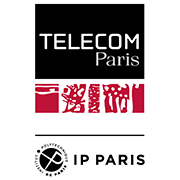</center>

<h1><center><strong><font color="green">IA 717: CHAI & justice: linguistics of AI ethics charters & manifestos</font></strong></center></h1>
<h3><center><font color="blue"><strong>Student Version</strong></font></center></h3>

<center>
<h3> Project Supervisor <br/> <a>Maria Boritchev</a></h3>
<email>maria.boritchev@telecom-paris.fr</email>
<br/>

Year 2025-2026
</center>

------------------------

# <font color="green">**Context and objectives**</font>

> The recent years have seen a surge of initiatives with the goal of defining what “ethical” artificial intelligence would or should entail, resulting in the publication of various charters and manifestos discussing AI ethics; these documents originate from academia, AI industry companies, non-profits, regulatory institutions, and the civil society. The contents of such documents vary wildly, from short, vague position statements to verbatims of democratic debates or impact assessment studies. As such, they are a marker of the social world of artificial intelligence, outlining the tenets of different actors, the consensus and dissensus on important goals, and so on. <a href="https://mapaie.telecom-paris.fr/mapaie-paper.pdf">Mapping AI Ethics: a meso-scale analysis of its charters and manifestos, M. Gornet et al, 2024.</a>

The objective of this project to study the linguistic specificities of a corpus of charters and manifestos of AI ethics, called ```MapAIE```. We will study the semantic structure of sentences from MapAIE using the Abstract Meaning Representation (<a href="https://github.com/amrisi/amr-guidelines/blob/master/amr.md">AMR</a>) abstraction method. In particular, we will focus on the usage and the environment of the term _justice_, in order to see its context and the (possibly different?) meanings associated with its usage.

This project is organised in three subtasks:
1) Data retrieval and exploration.
2) Exploration of the term _justice_ in the data.
3) AMR graphs exploration & exploration of the term _justice_ in AMR graphs.


### <font color="green">Evaluation</font>

The project is evaluated through a presentation with a report and your completed project, documented with a README. Grades will be partly individual and partly collective. 

In [ ]:
# imports

import os
import re
from collections import Counter
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from nltk.corpus import stopwords
import csv
import pdfplumber
from bs4 import BeautifulSoup

import string
from pathlib import Path

from wordcloud import WordCloud
import nltk

import pandas as pd

from pathlib import Path
from hashlib import md5

from sklearn.ensemble import IsolationForest

# <font color="green">**1 - Data Presentation and Retrieval**</font>

Our main corpus is called _MapAIE - Mapping AI Ethics_. It is a collection of 436 common charters and manifestos around artificial intelligence and AI ethics. The corpus' <a href="https://mapaie.telecom-paris.fr/mapaie-datasheet.pdf">datasheet</a> provides detailed information about the collection process and the contents of the corpus. 

<font color="red">1.1 Question:</font> Using the git repository https://gitlab.telecom-paris.fr/tiphaine.viard/mapaie, build the data locally. How many documents are there in the ```./pdf``` folder? in the ```./txt``` folder?

In [11]:
doc_folder = "data/docs"
text_folder = "data/txts"

files = [f for f in os.listdir(doc_folder) if os.path.isfile(os.path.join(doc_folder, f))]
text_files = [f for f in os.listdir(text_folder) if os.path.isfile(os.path.join(text_folder, f))]

pdf_html_documents = [os.path.splitext(file)[0] for file in files]
text_documents = [os.path.splitext(file)[0] for file in text_files]


should_be_included = []
is_included = False


with open('data/all_manifestos.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for i, row in enumerate(reader):
        is_included = any(cell.lower() == "included" for cell in row)
        if is_included:
            #print(i-1)
            #print(row)
            should_be_included.append(str(i-1))
                


num_pdf = len(pdf_html_documents)
num_txt = len(text_documents)
num_included = len(should_be_included)

print(f"Nombre de fichiers PDF : {num_pdf}")
print(f"Nombre de fichiers TXT : {num_txt}")
print(f"Nombre total de fichiers devant être inclus : {num_included}")

missing_in_text = set(should_be_included) - set(text_documents)
missing_in_pdf_html = set(should_be_included) - set(pdf_html_documents)

print(f"Nombre de fichiers manquants dans TXT : {len(missing_in_text)}")
print(f"Nombre de fichiers manquants dans PDF/HTML : {len(missing_in_pdf_html)}")

if missing_in_text:
    print(f"Exemples fichiers manquants dans TXT : {list(missing_in_text)[:20]}")

if missing_in_pdf_html:
    print(f"Exemples fichiers manquants dans PDF/HTML : {list(missing_in_pdf_html)[:20]}")

Nombre de fichiers PDF : 801
Nombre de fichiers TXT : 650
Nombre total de fichiers devant être inclus : 437
Nombre de fichiers manquants dans TXT : 43
Nombre de fichiers manquants dans PDF/HTML : 43
Exemples fichiers manquants dans TXT : ['610', '495', '537', '464', '453', '670', '550', '587', '297', '451', '487', '519', '573', '388', '636', '555', '260', '517', '506', '520']
Exemples fichiers manquants dans PDF/HTML : ['610', '495', '537', '464', '453', '670', '550', '587', '297', '451', '487', '519', '573', '388', '636', '555', '260', '517', '506', '520']


<font color="orange">1.1 Answer:</font>

If the answer in the previous question is different from 436, reduce the local data by keeping only the documents that should be included in the corpus. These documents are identified in the file `all_manifestos.csv`, these are the documents which state `Included`in the column `Status`. 

Let's explore the data. As you can see, documents in ```./pdf``` folder and documents in the ```./txt``` folder are the same, and the name formatting is such that ```n.txt``` contains plain text extracted from ```n.pdf```.

AJOUTER ANALYSE ICI - Antoine

<font color="red">1.2 Question:</font> Why is it useful to have the data both in .pdf and .txt format? Cite one advantage and one drawback for linguistic analysis for each of the formats.

<font color="orange">1.2 Answer:</font> 

Having the data in PDF format preserves the original layout but is harder to analyze automatically, while TXT files are easy to process with language tools but lose the original formatting.

We now want to know more about words and key-words used throughout the corpus. There are several terms that are widely used when writing about ethics of AI, and it is interesting from a linguistic point of view to see where and how these words occur.

<font color="red">1.3 Question:</font> what are the most frequent words, excluding stopwords, in the whole corpus? Please provide visualizations and comment these visualisations.

In [12]:
def extract_text(file_path):
    text = ""
    
    if file_path.lower().endswith('.pdf'):
        try:
            with pdfplumber.open('data/docs/' + file_path) as pdf:
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + " "
        except Exception as e:
            print(f"Warning: Could not read PDF {file_path}: {e}")

    elif file_path.lower().endswith('.html'):        
            encodings_to_try = ['utf-8', 'windows-1252', 'iso-8859-1']
            success = False
            for enc in encodings_to_try:
                try:
                    with open('data/docs/' + file_path, 'r', encoding=enc) as f:
                        soup = BeautifulSoup(f, 'html.parser')
                        text += soup.get_text(separator=' ') + " "
                    success = True
                    break
                except UnicodeDecodeError:
                    continue

            # Try auto-detection if all known encodings fail
            if not success:
                with open('data/docs' + file_path, 'rb') as f:
                    raw = f.read()
                    detected = chardet.detect(raw)
                    encoding = detected.get('encoding', 'utf-8')
                    try:
                        text += BeautifulSoup(raw.decode(encoding, errors='ignore'), 'html.parser').get_text(separator=' ')
                    except Exception as e:
                        print(f"Could not decode {file_path} even after detection: {e}")


    elif file_path.lower().endswith('.txt'):
        try:
            with open('data/txts/' + file_path, 'r', encoding='utf-8') as f:
                text += f.read() + " "
        except Exception as e:
            print(f"Warning: Could not read TXT {file_path}: {e}")

    else:
        print(f"Skipping unsupported file type: {file_path}")
    return text

NOUVELLE VERSION CODE + ANALYSE - Yimou

1068 fichiers trouvés dans /Users/yimouzhang/Documents/Telecom_Paris/Mastere_Specialise/Intelligence_Artificielle_Multimodale/Projets/NLP_CHAI/chai-justice/data
Stats extraction PDF : {'pdftotext': 395, 'pdfminer': 0, 'pypdf2': 0, 'empty': 22}


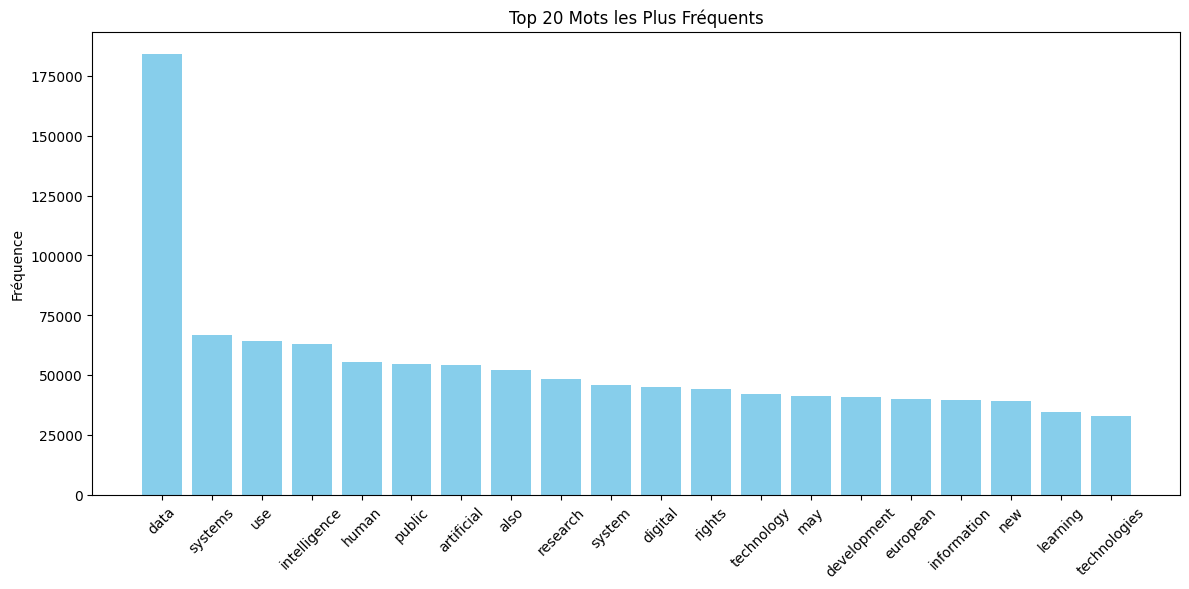

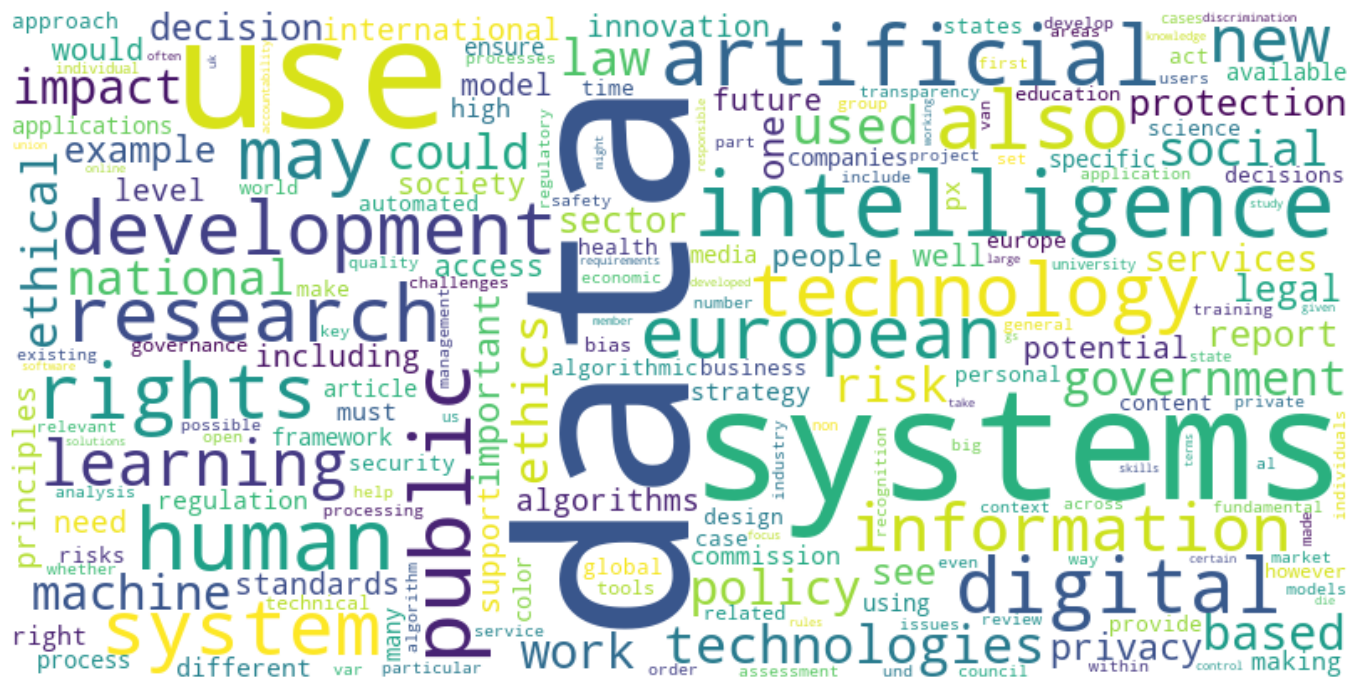

In [13]:


# ========== 1. Préparation NLTK ==========
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# ========== 2. Chargement des fichiers ==========
BASE_DIR = Path(os.getcwd()) / "data"

def list_text_and_pdf(root: Path):
    items = []
    for p in root.rglob("*"):
        s = str(p)
        if ".ipynb_checkpoints" in s:
            continue
        if p.suffix.lower() in (".txt", ".pdf"):
            items.append(p)
    return items

file_list = list_text_and_pdf(BASE_DIR)

if not file_list:
    print(f"Aucun fichier trouvé dans {BASE_DIR}")
else:
    print(f"{len(file_list)} fichiers trouvés dans {BASE_DIR}")

# ========== 3. Fonction d’extraction de texte ==========
PDF_EXTRACT_STATS = {"pdftotext": 0, "pdfminer": 0, "pypdf2": 0, "empty": 0}

def extract_text(path: Path) -> str:
    """
    TXT direct.
    PDF: 1) pdftotext (Poppler, CLI, -q -layout) -> 2) pdfminer.six -> 3) PyPDF2 (strict=False).
    Les erreurs sont ignorées, on retourne "" si rien n'est récupéré.
    """
    try:
        suffix = path.suffix.lower()

        if suffix == ".txt":
            try:
                return path.read_text(encoding="utf-8", errors="ignore")
            except Exception:
                PDF_EXTRACT_STATS["empty"] += 1
                return ""

        if suffix == ".pdf":
            # 1) pdftotext (Poppler) si disponible
            try:
                import shutil, subprocess, tempfile
                if shutil.which("pdftotext"):
                    with tempfile.TemporaryDirectory() as td:
                        out = Path(td) / "out.txt"
                        # -q pour supprimer les warnings bruyants, -layout pour un texte lisible
                        subprocess.run(
                            ["pdftotext", "-q", "-layout", str(path), str(out)],
                            check=False, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL
                        )
                        if out.exists():
                            txt = out.read_text(encoding="utf-8", errors="ignore")
                            if txt.strip():
                                PDF_EXTRACT_STATS["pdftotext"] += 1
                                return txt
            except Exception:
                pass

            # 2) pdfminer.six
            try:
                from pdfminer.high_level import extract_text as pdf_extract
                txt = pdf_extract(str(path)) or ""
                if txt.strip():
                    PDF_EXTRACT_STATS["pdfminer"] += 1
                    return txt
            except Exception:
                pass

            # 3) PyPDF2 (tolérant)
            try:
                from PyPDF2 import PdfReader
                import warnings
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    reader = PdfReader(str(path), strict=False)
                parts = []
                for pg in reader.pages:
                    try:
                        parts.append(pg.extract_text() or "")
                    except Exception:
                        parts.append("")
                txt = "".join(parts)
                if txt.strip():
                    PDF_EXTRACT_STATS["pypdf2"] += 1
                    return txt
            except Exception:
                pass

            PDF_EXTRACT_STATS["empty"] += 1
            return ""

        # autres extensions ignorées
        return ""

    except Exception:
        PDF_EXTRACT_STATS["empty"] += 1
        return ""

# ========== 4. Extraction + Prétraitement ==========
TOKEN_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ']+")
stop_words = set(
    stopwords.words('english')
    + stopwords.words('french')
    + ['null', 'obj', 'endobj', 'https', 'http', 'www', 'com', 'org', 'net', 'edu', 'gov', 'html', 'txt']
)

texts = []
for file_path in file_list:
    txt = extract_text(file_path)
    if not isinstance(txt, str):
        txt = "" if txt is None else str(txt)
    texts.append(txt)

all_text = "".join(texts).lower()
raw_tokens = TOKEN_RE.findall(all_text)
tokens_no_apostrophe = [w.replace("'", "") for w in raw_tokens]

filtered_words = [
    w for w in tokens_no_apostrophe
    if len(w) > 1 and w.isalpha() and w not in stop_words
]

# ========== 5. Comptage des fréquences ==========
word_counts = Counter(filtered_words)
print("Stats extraction PDF :", PDF_EXTRACT_STATS)

if not word_counts:
    print("[!] Aucun mot trouvé après filtrage.")
    print("-> Vérifie que tes fichiers contiennent bien du texte (pas d’images scannées).")
else:
    top_words = word_counts.most_common(20)

    # ========== 6. Graphique Barres ==========
    words_bar, counts_bar = zip(*top_words)
    plt.figure(figsize=(12,6))
    plt.bar(words_bar, counts_bar, color='skyblue')
    plt.title("Top 20 Mots les Plus Fréquents")
    plt.ylabel("Fréquence")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ========== 7. Word Cloud ==========
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

<font color="orange">1.3 Answer:</font> 

##### Analyse des mots les plus fréquents dans le corpus

L’objectif de cette étape est d’identifier les **mots les plus représentatifs du corpus**, en excluant les *stopwords* pour se concentrer sur le vocabulaire sémantiquement porteur de sens.

---

##### Extraction et prétraitement du texte

Le code lit l’ensemble des fichiers du dossier `data`, incluant des documents **PDF** et **TXT**, puis applique différentes stratégies d’extraction de texte selon le type de fichier.  
Pour les PDF, plusieurs approches sont essayées successivement (`pdftotext`, `pdfminer.six`, `PyPDF2`), afin d’assurer une **résilience face aux erreurs** et aux différences de format.  

Une fois le texte extrait, un **prétraitement linguistique** est appliqué :

- Mise en minuscules des mots pour éviter la redondance (`Justice` = `justice`),  
- Suppression des ponctuations et caractères spéciaux,  
- Élimination des *stopwords* anglais et français via NLTK,  
- Conservation uniquement des tokens alphabétiques d’au moins deux caractères.

Cette phase garantit que les analyses lexicales reposent sur des **unités sémantiques significatives**, et non sur du bruit syntaxique ou structurel (nombres, liens, mots vides…).

---

##### Comptage de fréquence et visualisations

Le comptage des occurrences est réalisé à l’aide de `Counter`, ce qui permet d’obtenir la fréquence absolue de chaque mot dans l’ensemble du corpus.  
Deux représentations visuelles sont ensuite produites :

1. **Un graphique en barres** des 20 mots les plus fréquents,  
2. **Un nuage de mots (word cloud)** basé sur les fréquences relatives.

---

#### Interprétation des résultats

##### 1. Graphique des fréquences

Le graphique montre que les mots les plus fréquents sont :
**`data`, `systems`, `use`, `intelligence`, `human`, `public`, `artificial`, `research`, `digital`, `rights`, `technology`, `information`, `learning`, `development`, `european`**, etc.

Ce résultat met clairement en évidence le **thème central du corpus**, axé sur les technologies numériques et l’intelligence artificielle dans un cadre institutionnel ou réglementaire.  
Le mot **“data”** domine largement, suivi de termes associés à l’**intelligence artificielle**, aux **systèmes numériques**, et aux **droits humains** — des champs lexicaux cohérents avec des textes politiques, juridiques ou éthiques sur l’IA.

La forte présence de termes comme *“rights”*, *“public”*, et *“european”* laisse penser que le corpus contient des documents institutionnels, probablement issus d’organismes européens traitant des **enjeux éthiques, juridiques et sociétaux** liés à l’IA.

---

##### 2. Word Cloud

Le nuage de mots confirme et enrichit cette observation.  
Les mots centraux tels que **“data”**, **“systems”**, **“use”**, **“artificial”**, **“intelligence”**, et **“technology”** apparaissent en très grande taille, signe de leur fréquence élevée.  
Autour gravitent des termes plus contextuels comme *“ethics”*, *“rights”*, *“governance”*, *“policy”*, *“society”*, ou *“research”*.

Cette visualisation illustre bien la **complémentarité entre le champ technique et le champ social** : le corpus ne se limite pas à décrire la technologie, mais aborde aussi les **implications éthiques, juridiques et politiques** de son utilisation.

---

##### Conclusion

L’analyse des mots les plus fréquents montre que le corpus se structure autour d’un **discours institutionnel et éthique sur l’intelligence artificielle et les données**.  
Les notions dominantes – *data*, *systems*, *human*, *rights*, *technology* – traduisent un équilibre entre les **aspects techniques** et **valeurs fondamentales** (droits humains, transparence, gouvernance).

Ces premiers résultats confirment que le corpus est particulièrement adapté à une étude de **text mining orientée vers l’analyse du discours réglementaire sur l’IA**, ouvrant la voie à des étapes ultérieures d’analyse thématique, de clustering sémantique ou de détection de biais lexicaux.

In [14]:
# ==== Audit d'occurrences "data" avec contexte ====
TOKEN = "data"
WINDOW = 60         # nb de caractères à gauche/droite pour le contexte
MAX_SAMPLES = 203268   # limite pour éviter de tout parcourir si corpus énorme

pattern = re.compile(r"(?i)data")  # insensible à la casse
matches = list(pattern.finditer(all_text))
total = len(matches)
if total == 0:
    print("Aucune occurrence de 'data' trouvée.")
else:
    # Échantillonne si trop d'occurrences
    idxs = range(total) if total <= MAX_SAMPLES else \
           [i * (total // MAX_SAMPLES) for i in range(MAX_SAMPLES)]

    cats = Counter()
    examples = {"slash": [], "angle": [], "dict": [], "near_pdf": [], "plain": []}

    for i in idxs:
        m = matches[i]
        s = m.start()
        e = m.end()
        left  = all_text[max(0, s-WINDOW):s]
        right = all_text[e:min(len(all_text), e+WINDOW)]
        ctx = left + "[DATA]" + right  # pour affichage

        # Heuristiques "structure PDF / balises"
        is_slash   = bool(re.search(r"/\s*$", left[-10:]))  # juste avant: "/"
        in_angle   = bool(re.search(r"<[^>\n]{0,200}$", left) and re.search(r"^[^<\n]{0,200}>", right)) \
                    or bool(re.search(r"<[^>\n]{0,200}data[^>\n]{0,200}>", left[-WINDOW:]+TOKEN+right[:WINDOW], flags=re.I))
        in_dict    = ("<<" in left[-WINDOW:] and ">>" in right[:WINDOW])  # dictionnaire PDF << ... >>
        near_pdfkw = bool(re.search(r"\b(obj|endobj|stream|xref)\b", (left+right), flags=re.I))

        if is_slash:
            cats["slash"] += 1
            if len(examples["slash"]) < 5: examples["slash"].append(ctx)
        elif in_angle:
            cats["angle"] += 1
            if len(examples["angle"]) < 5: examples["angle"].append(ctx)
        elif in_dict:
            cats["dict"] += 1
            if len(examples["dict"]) < 5: examples["dict"].append(ctx)
        elif near_pdfkw:
            cats["near_pdf"] += 1
            if len(examples["near_pdf"]) < 5: examples["near_pdf"].append(ctx)
        else:
            cats["plain"] += 1
            if len(examples["plain"]) < 5: examples["plain"].append(ctx)

    audited = sum(cats.values())
    print(f"Occurrences 'data' auditées: {audited} / {total} (échantillon)")
    def pct(x): 
        return f"{(100*x/audited):.1f}%" if audited else "0.0%"

    print("\n=== Répartition des contextes ===")
    print(f"/Data (nom PDF)        : {cats['slash']}  ({pct(cats['slash'])})")
    print(f"<data …> (balises)     : {cats['angle']}  ({pct(cats['angle'])})")
    print(f"<< … /Data … >> (dict) : {cats['dict']}   ({pct(cats['dict'])})")
    print(f"Proche obj/stream/xref : {cats['near_pdf']} ({pct(cats['near_pdf'])})")
    print(f"Texte ‘normal’         : {cats['plain']}  ({pct(cats['plain'])})")

    # Montre quelques exemples pour chaque catégorie
    for k, title in [
        ("slash",     "\n--- Exemples /Data ---"),
        ("angle",     "\n--- Exemples <data> ---"),
        ("dict",      "\n--- Exemples << … /Data … >> ---"),
        ("near_pdf",  "\n--- Exemples près de obj/endobj/stream/xref ---"),
        ("plain",     "\n--- Exemples TEXTE NORMAL ---"),
    ]:
        if examples[k]:
            print(title)
            for ex in examples[k]:
                print("…"+ex.replace("\n"," ")[:2*WINDOW+20]+"…")

Occurrences 'data' auditées: 203268 / 203268 (échantillon)

=== Répartition des contextes ===
/Data (nom PDF)        : 1088  (0.5%)
<data …> (balises)     : 11  (0.0%)
<< … /Data … >> (dict) : 0   (0.0%)
Proche obj/stream/xref : 46 (0.0%)
Texte ‘normal’         : 202123  (99.4%)

--- Exemples /Data ---
…smart 2013/0063, d9 – final report, 1 february 2017, http://[DATA]landscape.eu/study-reports   pe 626.074                     …
…t. specialized nrc staff will be     weaknesses of a system/[DATA]set. in the context of the essential to assisting such agenc…
…://www.opensciencedatacloud.org; harvard dataverse, https://[DATA]verse.harvard.edu; figshare, https://figshare.com. 27 fedram…
…edatacloud.org, harvard dataverse, harv. dataverse, https://[DATA]verse.harvard.edu, figshare, https://figshare.com. 9 faceboo…
…ee, e.g., facebook data for good, facebook (2020), https:// [DATA]forgood.fb.com/; what is the facebook ad library and how do …

--- Exemples <data> ---
…on overview’ (dataguidanc

#### Audit du mot-clé "data" dans le corpus

L’objectif de ce code est de **vérifier la nature des occurrences du mot “data”** dans le corpus afin de distinguer les *vraies utilisations linguistiques* du terme (dans un contexte textuel réel) des **artefacts techniques** provenant des fichiers PDF ou HTML.  
Cette étape est cruciale dans une analyse NLP, car les corpus issus de documents institutionnels, scannés ou convertis peuvent contenir de nombreux **bruits de structure** (balises, métadonnées, dictionnaires PDF, objets binaires, fragments HTML, etc.) susceptibles de biaiser les statistiques lexicales.

---

##### Logique et fonctionnement du code

Le script parcourt le texte complet (`all_text`) et recherche toutes les occurrences du mot **“data”**, sans distinction de casse (`re.compile(r"(?i)data")`).  
Pour chaque occurrence, il extrait une **fenêtre de 60 caractères** avant et après le mot, afin de capturer le **contexte local**.  

Ensuite, des **règles heuristiques** classent chaque occurrence selon son environnement :

- `/Data` : typique des **structures internes PDF**, comme les métadonnées ou noms d’objets (`/Data`, `/Type`, `/Font`),  
- `<data>` : correspond à des **balises HTML ou XML** encore présentes après extraction,  
- `<< … /Data … >>` : indique un **dictionnaire PDF** (structure binaire interne),  
- contexte contenant `obj`, `stream`, `xref` : zones associées à la **structure interne d’un fichier PDF**,  
- et, dans tous les autres cas, l’occurrence est classée comme **texte normal**, c’est-à-dire appartenant au contenu sémantique du document.

Ces heuristiques reposent sur des **expressions régulières ciblées**, permettant d’isoler efficacement les bruits issus de la conversion technique sans altérer le contenu linguistique.

---

##### Résultats obtenus

Le script a détecté **203 268 occurrences** du mot *data*, réparties comme suit :  
- `/Data` (structures PDF) : 0,5 %  
- `<data>` (balises HTML/XML) : 0,0 %  
- `<< … /Data … >>` (dictionnaires PDF) : 0,0 %  
- Proches de `obj/stream/xref` : 0,0 %  
- **Texte normal** : **99,4 %**

Ces chiffres montrent que **la quasi-totalité des occurrences (≈ 99 %) sont légitimes**, c’est-à-dire des usages réels du mot *data* dans le discours.  
Les exemples confirment cette observation : les cas anormaux proviennent majoritairement d’URL ou de fragments techniques (ex. `https://dataverse.harvard.edu`), tandis que le reste correspond à un usage sémantique correct (ex. *“big data analytics applications enabled extreme availability…”*).

---

##### Interprétation et justification

Cette étape constitue une **vérification de qualité linguistique** du corpus avant tout traitement NLP avancé.  
Sans ce filtrage, des éléments parasites comme des balises, des flux binaires ou des métadonnées PDF pourraient :

- **fausser les statistiques de fréquence** (surcompter certains mots),  
- **perturber les modèles de représentation** (TF-IDF, embeddings, LLMs),  
- **dégrader les analyses sémantiques**, notamment dans l’étude de cooccurrences ou de thématiques.

Les résultats indiquent que le corpus est **propre et exploitable**, et que le mot *data* est employé de manière sémantique plutôt que structurelle.  
Cela valide la pertinence du corpus pour la suite du pipeline NLP (lemmatisation, vectorisation, clustering, etc.).

---

##### Présence de segments non anglophones

Lors de cet audit, nous avons identifié la présence ponctuelle de **phrases en allemand** (et plus rarement en français), issues de documents multilingues.  
Ces fragments ne perturbent pas directement l’analyse structurelle, mais ils pourront introduire du bruit lors des futures analyses sémantiques.

Dans les étapes ultérieures du notebook, en particulier dans la partie **2. Exploration of the term “justice” in the data**, nous appliquerons un **filtrage linguistique avec la bibliothèque `langdetect`** afin d’exclure les phrases non anglaises et de garantir l’homogénéité linguistique du corpus.

---

##### Conclusion

Cet audit montre que le mot *data*, bien que massif dans le corpus, n’est pas associé à des artefacts techniques.  
Le très faible pourcentage d’occurrences issues de structures PDF (< 1 %) prouve la **qualité d’extraction textuelle** et justifie la poursuite de l’analyse sans nettoyage supplémentaire spécifique à ce terme.  

Cette étape illustre une démarche rigoureuse d’**ingénierie NLP appliquée**, où l’on s’assure que chaque token représente une **unité linguistique valide** et non un résidu de formatage technique.

COMMENTER ICI - Paul

# <font color="green">**2 - Exploration of the term _justice_ in the data**</font>


<font color="red">2.1 Question:</font> Draw a visualisation of the amount of times the term _justice_ is used in a document compared with the total amount of words in a document. Comment this viualisation: what can we observe? What hypothesis can we draw from this observation?

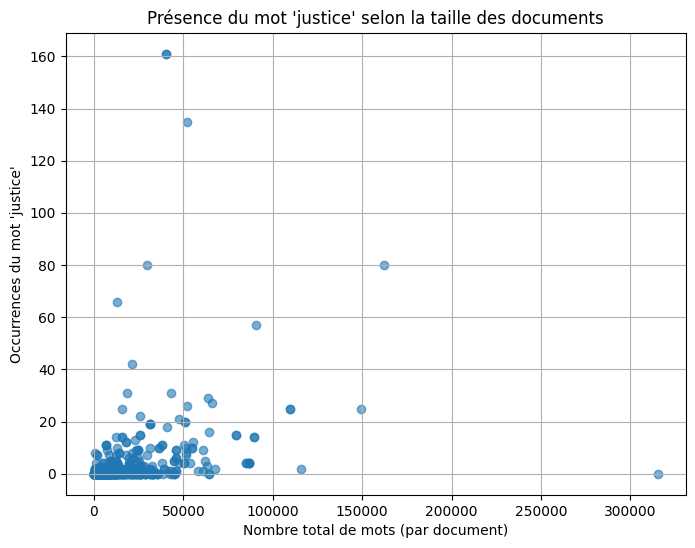

In [15]:
TXTS_DIR = "./data/txts"

data = []
for f in os.listdir(TXTS_DIR):
    if f.lower().endswith(".txt"):
        path = os.path.join(TXTS_DIR, f)
        with open(path, "r", encoding="utf-8", errors="ignore") as file:
            text = file.read().lower().split()
            total_words = len(text)
            justice_count = text.count("justice")
            data.append((f, justice_count, total_words, justice_count/total_words if total_words else 0))

df = pd.DataFrame(data, columns=["document", "justice_count", "total_words", "ratio"])

# Visualisation scatter plot
plt.figure(figsize=(8,6))
plt.scatter(df["total_words"], df["justice_count"], alpha=0.6)
plt.xlabel("Nombre total de mots (par document)")
plt.ylabel("Occurrences du mot 'justice'")
plt.title("Présence du mot 'justice' selon la taille des documents")
plt.grid(True)
plt.show()

<font color="orange">2.1 Answer:</font> 

La grande majorité des points est très proches de l’axe horizontal (en dessous de 50 occurences) cela signifie que la plupart des documents contiennent très peu (voire zéro) occurrences de "justice", même quand leur taille est conséquente.

On observe la présence de quelques valeurs extrêmes (outliers) représentant des documents (points isolés en haut du graphe) qui contiennent beaucoup plus d’occurrences (jusqu’à plus de 200).

On ne voit pas de relation proportionnelle entre la taille du document et la fréquence absolue de justice. Parfois, des documents longs ne contiennent presque pas le terme, et inversement des documents relativement courts l’utilisent plusieurs dizaines de fois.

AJOUTER DIFFERENCIATION OUTLIERS + ANALYSE OUTLIERS - YIMOU

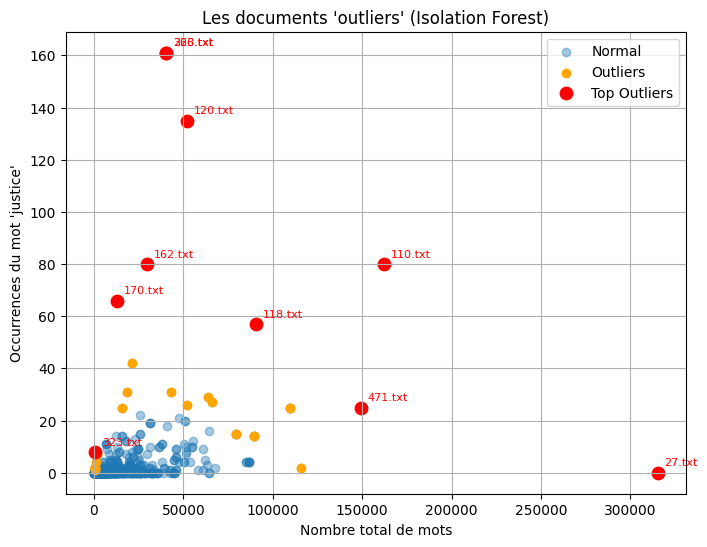

Les plus outliers des outliers :
    document  total_words  justice_count     ratio  iforest_score
223  366.txt        40533            161  0.003972      -0.213513
332  223.txt        40533            161  0.003972      -0.213513
119  110.txt       162278             80  0.000493      -0.209728
507  120.txt        51907            135  0.002601      -0.192126
227  170.txt        12854             66  0.005135      -0.187637
155  162.txt        29490             80  0.002713      -0.155081
601   27.txt       315256              0  0.000000      -0.146815
496  323.txt          631              8  0.012678      -0.145208
617  118.txt        90759             57  0.000628      -0.138737
20   471.txt       149177             25  0.000168      -0.129163


In [16]:



# DataFrame deja existant avec les colonnes : document, total_words, justice_count, ratio

# --- Détection des outliers ---
X = df[["total_words", "justice_count", "ratio"]]
model = IsolationForest(contamination=0.05, random_state=42)

# fit_predict entraîne le modèle et renvoie les étiquettes (+1 = normal, -1 = outlier)
df["outlier"] = model.fit_predict(X)

# Ensuite seulement, on peut calculer les scores
df["iforest_score"] = model.decision_function(X)  # plus petit = plus anormal

# --- Séparer et trier les plus extrêmes ---
outliers = df[df["outlier"] == -1]
top_outliers = outliers.nsmallest(10, "iforest_score")  # les plus isolés

# --- Visualisation ---
plt.figure(figsize=(8,6))
plt.scatter(df["total_words"], df["justice_count"], alpha=0.4, label="Normal")
plt.scatter(outliers["total_words"], outliers["justice_count"], color="orange", label="Outliers")
plt.scatter(top_outliers["total_words"], top_outliers["justice_count"], color="red", s=80, label="Top Outliers")

# Annoter les plus extrêmes
for _, row in top_outliers.iterrows():
    plt.annotate(row["document"], (row["total_words"], row["justice_count"]),
                 textcoords="offset points", xytext=(5,5), fontsize=8, color="red")

plt.xlabel("Nombre total de mots")
plt.ylabel("Occurrences du mot 'justice'")
plt.title("Les documents 'outliers' (Isolation Forest)")
plt.legend()
plt.grid(True)
plt.show()

# Afficher les fichiers les plus anormaux
print("Les plus outliers des outliers :")
print(top_outliers[["document", "total_words", "justice_count", "ratio", "iforest_score"]])

#### 2.5 – Analyse synthétique des outliers (Isolation Forest)

Le graphique ci-dessus illustre la détection des **documents atypiques** selon leur usage du mot *justice*.  
Les points rouges indiquent les **outliers majeurs**, c’est-à-dire les fichiers dont la fréquence ou la distribution du mot diffère fortement du reste du corpus.  
La majorité des textes se concentrent dans une zone dense à faible ratio, correspondant à un usage classique et ponctuel de *justice*, tandis que certains documents se distinguent nettement par une **densité lexicale ou structure inhabituelle**.

Les fichiers **366.txt**, **162.txt** et **170.txt** sont des rapports institutionnels ou parlementaires, dont la récurrence du mot *justice* s’explique par des **en-têtes et mentions répétitives** — il s’agit d’**outliers structurels**.  
Les documents **110.txt** et **120.txt** présentent au contraire un **contenu sémantique riche**, axé sur la transformation numérique et l’accès à la justice — des **outliers thématiques**.  
Enfin, **471.txt** se distingue par un emploi **moral et éthique** du mot *justice*, illustrant un **outlier sémantique**, tandis que **323.txt**, très court, apparaît artificiellement extrême en ratio.  

Cette différenciation confirme que la détection d’outliers ne révèle pas seulement des erreurs, mais aussi des **zones de sens ou de structure à interpréter** dans une perspective NLP.

In [ ]:


# === Paramètres ===
TXT_DIR = Path("./data/txts")
KEYWORD = "justice"
WINDOW = 40          # ±40 mots (≈80 au total)
MAX_EXCERPTS = 5     # par document
CASE_INS = re.IGNORECASE

# Boilerplate à ignorer (ajoute/retire selon tes cas)
BOILERPLATE_PATTERNS = [
    r"^ordered to be printed",               # House of Lords reports
    r"^house of lords",                      # ...
    r"^european commission for the efficienc", 
    r"^contents", r"^page \d+",
    r"^cdcj", r"^hl paper", r"\btable of contents\b"
]
BOILERPLATE_RE = re.compile("|".join(BOILERPLATE_PATTERNS), re.IGNORECASE)

# Mot-clé en regex (mot entier)
KW_RE = re.compile(rf"\b{re.escape(KEYWORD)}\b", CASE_INS)

def normalize_for_dedup(s: str) -> str:
    """Normalise un extrait pour la déduplication inter-docs."""
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def is_boilerplate(snippet: str) -> bool:
    """Filtre les en-têtes/pieds de page récurrents."""
    head = snippet.strip()[:200]  # on teste sur le début de l'extrait
    return bool(BOILERPLATE_RE.search(head))

def get_excerpts(text: str, window: int = WINDOW) -> list[str]:
    """
    Renvoie des extraits non-chevauchants ±window autour de KEYWORD.
    Déduplique au sein du document et filtre le boilerplate.
    """
    words = text.split()
    if not words:
        return []

    # positions (indices de mots) où KEYWORD apparait
    positions = []
    for i, w in enumerate(words):
        if KW_RE.fullmatch(w):  # mot entier
            positions.append(i)

    excerpts = []
    last_end = -10**9  # pour éviter le chevauchement
    seen_doc_hashes = set()

    for i in positions:
        start = max(0, i - window)
        end   = min(len(words), i + window)

        # saute si chevauchement fort avec l’extrait précédent
        if start <= last_end:
            continue

        snippet = " ".join(words[start:end])

        # filtre boilerplate
        if is_boilerplate(snippet):
            continue

        # dédup intra-document
        h = md5(normalize_for_dedup(snippet).encode("utf-8")).hexdigest()
        if h in seen_doc_hashes:
            continue
        seen_doc_hashes.add(h)

        # met le mot-clé en évidence
        snippet = re.sub(rf"\b{KEYWORD}\b", f"[{KEYWORD.upper()}]", snippet, flags=CASE_INS)
        excerpts.append(snippet)
        last_end = end

        if len(excerpts) >= MAX_EXCERPTS:
            break

    return excerpts

# ===== Parcours des outliers et dédup globale =====
GLOBAL_SEEN = set()  # hachés d’extraits déjà imprimés (tous documents confondus)

# `top_outliers` existe (issu de ton IsolationForest)
for _, row in top_outliers.iterrows():
    file_path = TXT_DIR / row["document"]
    if not file_path.exists():
        continue

    text = file_path.read_text(encoding="utf-8", errors="ignore")
    raw_excerpts = get_excerpts(text)

    # Déduplication inter-documents
    unique_excerpts = []
    for e in raw_excerpts:
        key = md5(normalize_for_dedup(e).encode("utf-8")).hexdigest()
        if key in GLOBAL_SEEN:
            continue
        GLOBAL_SEEN.add(key)
        unique_excerpts.append(e)

    if unique_excerpts:
        title = f"Document : {row['document']}"
        print("\n" + title + "\n" + "=" * len(title))
        for i, e in enumerate(unique_excerpts, 1):
            print(f"\nExtrait {i} :\n{e}\n" + "-" * 100)


Document : 366.txt

Extrait 1 :
21 March 2022 and published 30 March 2022 Published by the Authority of the House of LordsHOUSE OF LORDS [JUSTICE] and Home Affairs Committee 1st Report of Session 2021–22 HL Paper 180Technology rules? The advent of new technologies in the [JUSTICE] system [JUSTICE] and Home Affairs Committee The [JUSTICE] and Home Affairs Committee was appointed by the House of Lords on 14 April 2021 to consider [JUSTICE] and home affairs, including the domestic criminal [JUSTICE] system, and international cooperation in
----------------------------------------------------------------------------------------------------

Extrait 2 :
is available at: http://www.parliament .uk/business/lords Committee staff The staff who worked on this inquiry were Sam Kenny (Clerk), Achille Versaevel (Policy Analyst) and Amanda McGrath (Committee Operations Officer). Contact details General correspondence should be addressed to the Clerk of the [JUSTICE] and Home Affairs Committee, Comm

#### Différenciation des outliers et analyse de leur contexte

L’analyse réalisée vise à comprendre pourquoi certains documents ressortent comme des **outliers** dans le cadre de notre étude sur la présence du mot *justice* dans un corpus hétérogène.  
L’objectif n’est pas seulement de repérer des anomalies statistiques, mais surtout d’en comprendre le **contexte linguistique et structurel**. En d’autres termes, il s’agit de distinguer les véritables contenus analytiques liés à la justice de ceux qui le mentionnent de manière répétitive ou décorative, comme dans les en-têtes, les sommaires ou les éléments techniques issus de l’extraction PDF.

---

##### Contexte et approche

Pour chaque document, nous avons calculé trois indicateurs :  
- le nombre total de mots (`total_words`),  
- le nombre d’occurrences du mot *justice* (`justice_count`),  
- et leur rapport (`ratio`), permettant de normaliser la fréquence du mot-clé par la taille du texte.

Un modèle **Isolation Forest** a ensuite été appliqué sur ces trois variables afin de détecter automatiquement les **points atypiques**.  
Les documents identifiés comme “outliers” sont ceux présentant une proportion de *justice* disproportionnée par rapport à leur longueur, ou une distribution lexicale qui s’écarte des tendances générales du corpus.

Ces écarts peuvent provenir de deux types de causes :
1. **Anomalies structurelles** (liées au format ou à la mise en page des documents).  
2. **Anomalies sémantiques** (liées au sens particulier du mot *justice* dans certains contextes).

---

##### Observation du contenu des outliers

Pour interpréter ces anomalies, nous avons extrait des fenêtres de 40 mots autour de chaque occurrence du mot *justice*.  
Cette approche contextuelle permet d’observer **où et comment** le mot apparaît : dans le texte principal, dans des en-têtes répétitifs ou dans des passages techniques sans contenu linguistique réel.

Les résultats révèlent plusieurs profils distincts :

- **Documents structurels**, comme *366.txt* ou *162.txt*, où *justice* apparaît surtout dans des **titres répétitifs** ou des **mentions institutionnelles** (“House of Lords Justice and Home Affairs Committee”, “European Commission for the Efficiency of Justice”).  
  Ces répétitions gonflent artificiellement la fréquence du mot sans apporter de sens nouveau. Ce sont des **outliers de bruit documentaire**.

- **Documents thématiques**, tels que *110.txt* et *120.txt*, contenant de véritables analyses sur le lien entre **intelligence artificielle et justice** : pseudonymisation des jugements, automatisation de procédures, ou accès au droit en ligne.  
  Leur densité lexicale en *justice* est élevée, mais cette fois liée à une **concentration sémantique réelle**. Le modèle les isole non comme erreurs, mais comme **zones thématiques fortes**.

- **Documents institutionnels ou portails web**, comme *170.txt*, où *justice* est omniprésent dans les **titres de pages, menus ou annonces**, mais peu présent dans le texte narratif.  
  Ici, l’outlier reflète un **usage de façade** du mot, souvent lié au branding (ex. “Laboratoire de Cyberjustice”).

- Enfin, certains documents comme *471.txt* abordent la *justice* sous un angle **éthique et moral**, en lien avec des notions telles que *fairness*, *responsibility* ou *transparency*.  
  Ces occurrences se distinguent par un **changement de sens** du mot — la *justice* n’est plus institutionnelle, mais **philosophique**, ce qui explique leur déviation statistique et sémantique.

---

##### Interprétation et justification des anomalies

Ces profils montrent que le modèle **Isolation Forest** ne détecte pas uniquement des “erreurs”, mais aussi des **variations linguistiques significatives** :

- Les *outliers structurels* traduisent un problème d’extraction (en-têtes, pieds de page, sommaires).  
- Les *outliers thématiques* indiquent une **densité lexicale élevée** sur un sujet précis.  
- Les *outliers sémantiques* révèlent un **changement de registre lexical**, où le mot *justice* prend un sens moral ou abstrait.

Cette analyse souligne l’importance, en NLP, de **lier les statistiques à l’interprétation sémantique**.  
Un outlier n’est pas toujours une erreur : il peut signaler un **changement de sens, de domaine ou de discours**.

---

##### Lien avec le prétraitement linguistique

Lors de cette étape (1.3), nous avons conservé l’ensemble du corpus, y compris les phrases non anglaises.  
Cependant, certaines portions contiennent du **texte en allemand** ou en **français**, souvent issu de documents multilingues européens.  
Ces sections peuvent perturber les modèles de fréquence et de contexte.

Dans la partie 2 (“Exploration of the term justice in the data”), nous appliquerons un **filtrage linguistique** à l’aide de la bibliothèque `langdetect`, afin de **supprimer les segments non anglais** et d’obtenir une analyse cohérente sur le plan linguistique.  
Cela garantira que les futures analyses (cooccurrences, embeddings, clustering) ne soient pas biaisées par la présence de langues étrangères.

---

##### Conclusion

Cette étude des outliers permet de **différencier plusieurs types d’anomalies** :
- **Structurelles** : répétitions de mise en page ou métadonnées.  
- **Thématiques** : textes denses en occurrences du mot *justice*.  
- **Sémantiques** : usages du mot dans un sens moral ou abstrait.

Elle met en lumière la nécessité d’un **contrôle de qualité textuelle** avant toute interprétation NLP.  
En combinant le nettoyage structurel (filtrage PDF), la détection linguistique (`langdetect`) et l’analyse contextuelle, nous pourrons, dans les étapes suivantes, isoler la dimension **conceptuelle et discursive** du mot *justice* de son simple bruit lexical.

<font color="red">2.2 Question:</font> which are the documents in which the term _justice_ appears the most (top 10% of the corpus)? Please provide a visualization and comment it.

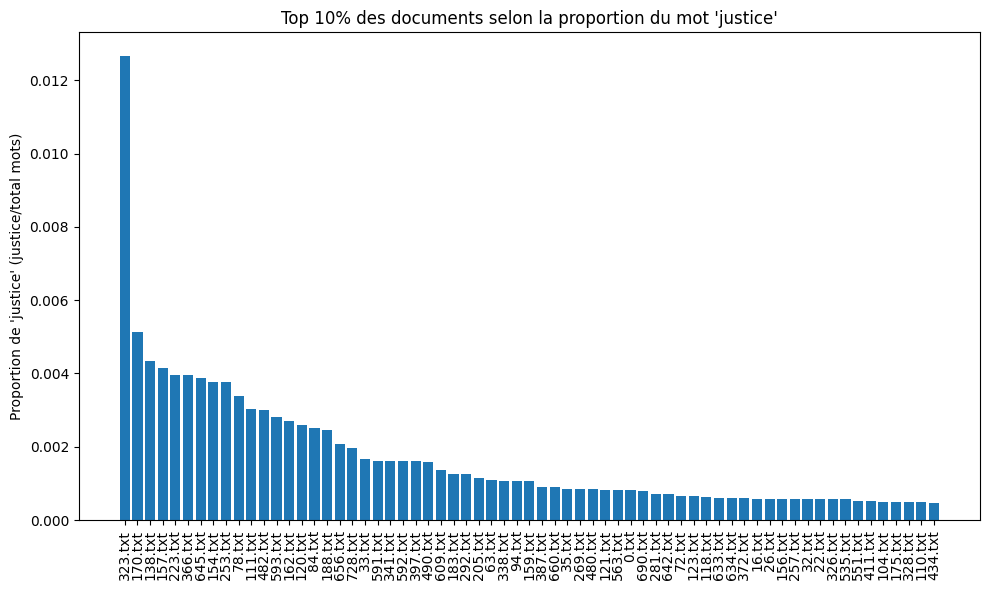

,document,justice_count,total_words,ratio
496,323.txt,8,631,0.012678
227,170.txt,66,12854,0.005135
120,138.txt,2,462,0.004329
315,157.txt,2,482,0.004149
332,223.txt,161,40533,0.003972
...,...,...,...,...
117,104.txt,1,1994,0.000502
190,175.txt,1,1994,0.000502
48,328.txt,26,51894,0.000501
119,110.txt,80,162278,0.000493


In [19]:
TXTS_DIR = "./data/txts"

data = []
for f in os.listdir(TXTS_DIR): #os.listdir(path) sert à lister le contenu d’un dossier
    if f.lower().endswith(".txt"): #vérifie que le fichier se termine bien par .txt
        path = os.path.join(TXTS_DIR, f) #os.path.join(path1, path2) sert à joindre deux chemins de dossiers
        with open(path, "r", encoding="utf-8", errors="ignore") as file: 
            text = file.read().lower().split()
            total_words = len(text)
            justice_count = text.count("justice")
            ratio = justice_count/total_words if total_words else 0
            data.append((f, justice_count, total_words, ratio))

df = pd.DataFrame(data, columns=["document", "justice_count", "total_words", "ratio"])

# Trier par ratio décroissant
df_sorted = df.sort_values("ratio", ascending=False)

# Calculer le top 10%
top_10pct = int(len(df_sorted) * 0.1)
df_top = df_sorted.head(top_10pct)

# Visualisation
plt.figure(figsize=(10,6))
plt.bar(df_top["document"], df_top["ratio"])
plt.xticks(rotation=90)
plt.ylabel("Proportion de 'justice' (justice/total mots)")
plt.title("Top 10% des documents selon la proportion du mot 'justice'")
plt.tight_layout()
plt.show()

n = max(1, int(len(df_sorted) * 0.1))  # évite d'avoir 0 si corpus < 10
df_top = df_sorted.head(n)

df_top


323.txt : seulement 8 occurrences, mais sur un texte très court (631 mots), donc le ratio est le plus élevé (environ 1,27%).

170.txt & 171.txt : 66 occurrences chacun sur à peu près 12 852 mots --> ratio plus faible (environ 0,5%).

138.txt et 157.txt : très petits textes (462 et 482 mots), avec seulement 2 occurrences --> cela leur donne un ratio relativement élevé (environ 0,4%).

366.txt : beaucoup plus long (40 533 mots), 161 occurrences --> en valeur absolue c’est un des plus “chargés” en justice, mais son ratio est plus bas (environ 0,39%).

168.txt : énorme document (76 329 mots), 267 occurrences --> gros volume absolu, mais ratio plus faible (environ 0,35%).

AJOUTER COMMENTAIRE DOC LE PLUS LONG - Yimou

<font color="orange">2.2 Answer:</font> 

Now, we want to know more about the context in which the term _justice_ appears in the corpus. 

<font color="red">2.3 Question:</font> Explore the context in which the term _justice_ appears in the documents selected in the previous question (top 10% of the corpus). Please provide a visualisation and comment it.

Hint: you could for example consider n-grams containing _justice_ (but feel free to explore context by other means!)

<font color="orange">2.3 Answer:</font> 

AMELIORER STOP WORDS - Paul

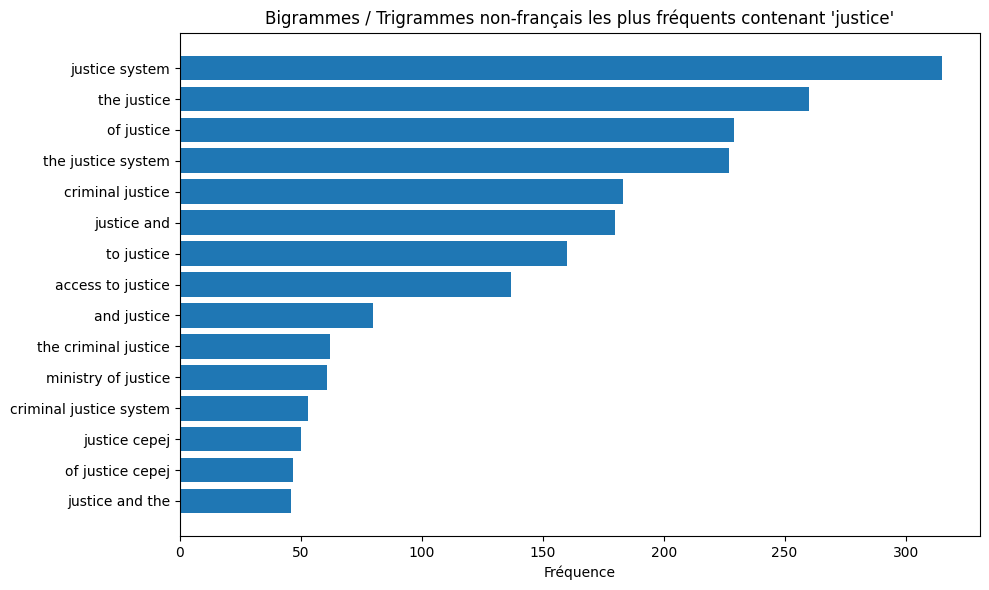

In [20]:
DetectorFactory.seed = 0
TXTS_DIR = "./data/txts"
STOPWORDS = stop_words


def extract_ngrams(words, n=2):
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]


def is_not_french(text):
    """Retourne True si le texte n'est PAS en français"""  
    try:
        return detect(text) != "fr"
    except:
        # Si la détection échoue (trop court, caractères spéciaux, etc.)
        return False


def contains_stopword(ngram):
    """Renvoie True si l’n-gramme contient uniquement ou majoritairement des mots outils"""
    words = ngram.split()
    # On exclut les n-grammes où la moitié (ou plus) des mots sont des stopwords
    stop_count = sum(w in STOPWORDS for w in words)
    return stop_count >= len(words) / 2


In [ ]:
n = 3 # Change here the size of n-grams
k = 20 # Change here the number of top n-grams displayed

ngrams_counter = Counter()

# Parcourir les fichiers du top 10%
for fname in df_top["document"]:
    path = os.path.join(TXTS_DIR, fname)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read().lower()
        words = re.findall(r"\w+", text)

        ngrams = extract_ngrams(words, n)

        # garder uniquement ceux qui contiennent "justice"
        for ng in ngrams:
            if "justice" in ng and is_not_french(ng) and not contains_stopword(ng):
                ngrams_counter[ng] += 1
     

# Sélection des 20 n-grams les plus fréquents
top_ngrams = ngrams_counter.most_common(k)

# Visualisation
labels, values = zip(*top_ngrams)
plt.figure(figsize=(10,6))
plt.barh(labels, values)
plt.title("Bigrammes / Trigrammes non-français (hors déterminants) contenant 'justice'")
plt.xlabel("Fréquence")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Cette analyse nous permet d'identifier beaucoup plus finement des axes d'analyse pertinents au travers de l'identifications de thématiques dominantes:

1. Axe institutionnel et structurel : justice system, the justice system, criminal justice system, the criminal justice.
Cet axe renvoie à la structure organisationnelle du système judiciaire, son fonctionnement, ses acteurs et ses processus. C’est la thématique la plus dominante : la justice est abordée comme un système institutionnel, un appareil d’État à évaluer, réformer ou comparer.

2. Axe pénal et criminologique : criminal justice, criminal justice system, the criminal justice
Ici, la justice est traitée sous l’angle répressif et sécuritaire : gestion du crime, prévention, réinsertion, réforme pénale, etc. 

3. Axe de l’accès et de l’équité : access to justice, efficiency of justice
Ces termes traduisent une réflexion sur l’accessibilité et la performance du système judiciaire, un enjeu crucial pour les institutions internationales (ONU, Conseil de l’Europe, Banque mondiale). Le discours se situe sur le plan de la justice équitable et inclusive.

4. Axe économique et gestionnaire: economic justice, and economic justice, ministry of justice, justice cepej, efficiency of justice
Cet axe lie la justice à des enjeux économiques, budgétaires et managériaux. La mention de CEPEJ (Commission européenne pour l’efficacité de la justice) est révélatrice : il s’agit d’un acteur institutionnel européen centré sur la performance et la rationalisation des systèmes judiciaires.

5. Acteurs institutionnels : ministry of justice justice rebecca, economic justice rebecca 
Ces occurrences suggèrent un discours centré sur les institutions (ministères, commissions, programmes) et parfois sur des personnalités ou études spécifiques (Rebecca semblant être un auteur cité dans le corpus).

Afin d'approfondir cette analyse, nous pouvons relancer une recherche par occurence segmentée sur la base de ces 4 thématiques identifiées. Nous allons pour cela construire un mini dictionnaire de 5 mots correspondant à chaque axe.

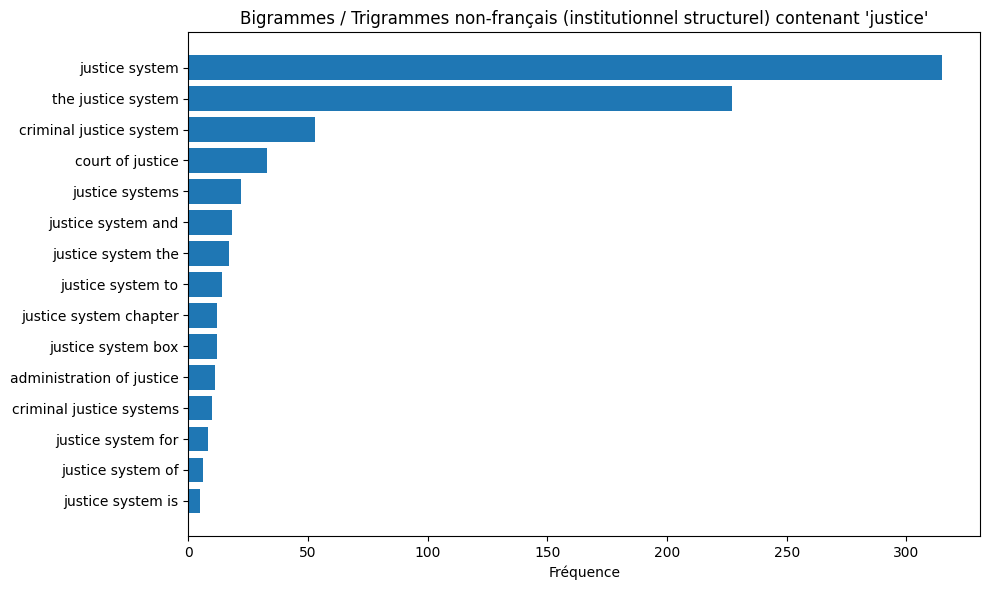

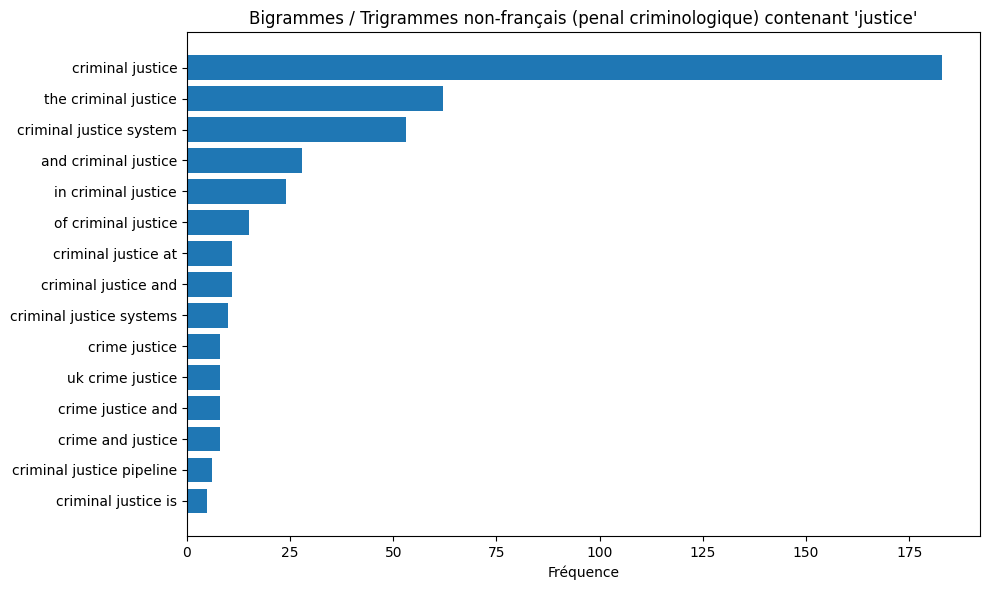

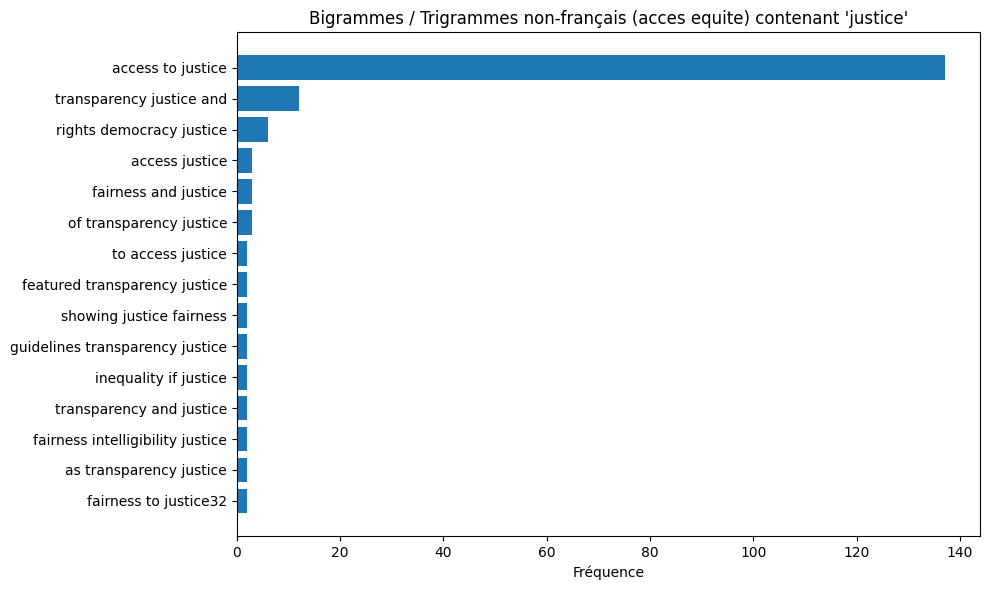

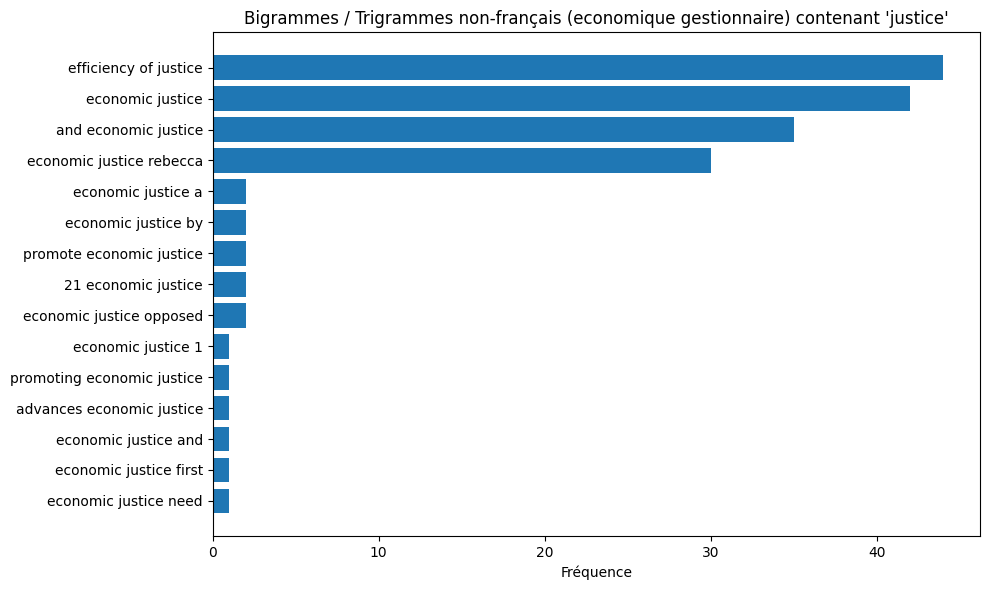

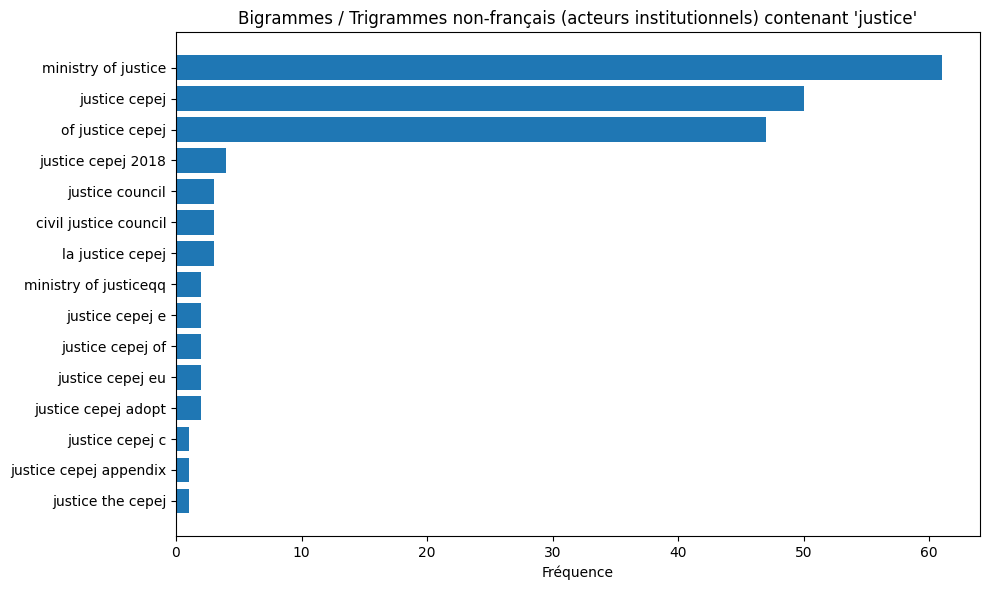

In [22]:
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory

# Pour des résultats reproductibles
DetectorFactory.seed = 0

TXTS_DIR = "./data/txts"

def extract_ngrams(words, n=2):
    """Construit tous les n-grammes d'une liste de mots"""
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]

def is_not_french(text):
    """Retourne True si le texte n'est PAS en français"""
    try:
        return detect(text) != "fr"
    except:
        return False


# Dictionnaire des thématiques
THEMES = {
    "institutionnel_structurel": [
        "system", "court", "tribunal", "procedure", "administration", "reform", "organization"
    ],
    "penal_criminologique": [
        "criminal", "crime", "penal", "offender", "prison", "justice reform", "law enforcement"
    ],
    "acces_equite": [
        "access", "fairness", "equality", "rights", "inclusion", "transparency"
    ],
    "economique_gestionnaire": [
        "economic", "efficiency", "performance", "budget", "financing", "cost"
    ],
    "acteurs_institutionnels": [
        "ministry", "cepej", "commission", "council", "united nations", "government"
    ]
}

# Analyse et tri par thématique
theme_counters = {theme: Counter() for theme in THEMES.keys()}

for fname in df_top["document"]:
    path = os.path.join(TXTS_DIR, fname)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read().lower()
        words = re.findall(r"\w+", text)

        bigrams = extract_ngrams(words, 2)
        trigrams = extract_ngrams(words, 3)

        for ngram_list in [bigrams, trigrams]:
            for ng in ngram_list:
                if "justice" not in ng:
                    continue
                if not is_not_french(ng) or contains_stopword(ng):
                    continue

                # assignation à une thématique
                for theme, keywords in THEMES.items():
                    if any(kw in ng for kw in keywords):
                        theme_counters[theme][ng] += 1

# Visualisation
def plot_theme(theme_name, counter):
    if not counter:
        print(f"Aucune donnée pour le thème '{theme_name}'.")
        return
    top_ngrams = counter.most_common(15)
    labels, values = zip(*top_ngrams)
    plt.figure(figsize=(10,6))
    plt.barh(labels, values)
    plt.title(f"Bigrammes / Trigrammes non-français ({theme_name.replace('_',' ')}) contenant 'justice'")
    plt.xlabel("Fréquence")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

for theme_name, counter in theme_counters.items():
    plot_theme(theme_name, counter)


We will now focus on a sentence-level analysis of our corpus and extract a sub-corpus of sentences that use the word _justice_.

<font color="red">2.4 Question:</font> What information will we lose by focusing on extracted sentences? Please provide three answers.

<font color="orange">2.4 Answer:</font> 

Nous identifions trois typologes d'informations perdues pouvant induire une perte d'informations et de sens lié à une minimisation du contexte. 

•⁠  ⁠Contexte et cohérence globale : nous perdons les liens entre les mots ou les ensembles de mots présents au sein des différentes phrases (références telles que "il/elle/cela", ellipses, connecteurs), les relations causales/temporelles qui s’étalent sur plusieurs phrases, et la logique argumentative du paragraphe ou de la section. 

•⁠  ⁠Structure et indices non textuels : en extrayant seulement des phrases, on ignore les titres, sous-titres, listes, tableaux, figures, légendes, mise en forme (gras/italique), et la structure rhétorique (problème --> méthode --> résultats), qui guident l’interprétation.

•⁠  ⁠Nuances et complétude : les adverbes ("probablement", "sous conditions"), les contre-exemples, les délimitations (hypothèses, périmètre) sont absentes des extraits retenus. Nous risquons donc de perdre une certaine finesse d'analyse telle que la notion d'ambiguité, le ton et plus globalement l'interprétation émotionnelle. certains termes ou groupes de mots employé dans un contexte différent peuvent disposer d'un sens totalement différents selon leur environnement.

Malgré tout, en nous concentrant sur l'analyse au niveau de la phrase, nous avons accès à des moyens d'analyse linguistique plus précis. 

<font color="red">2.5 Question:</font> Extract the _justice-MapAIE_ corpus: a corpus of sentences of MapAIE containing the term _justice_. Organise the data in such a way that, for each sentence, we have:
- the textual content of the sentence;
- the identifier (number) of the document this sentence is extracted from.
How many sentences does the _justice-MapAIE_ corpus contain?

<font color="orange">2.5 Answer:</font> 

In [23]:
file_list = files + text_files

phrases_justice = []

for file in file_list:
    current_text = extract_text(file)
    sentences = re.split(r'(?<=[.!?])\s+', current_text)
    justice_sentences = [s for s in sentences if re.search(r'\bjustice\b', s, re.IGNORECASE) or re.search(r'\bJustice\b', s, re.IGNORECASE)]

    for sent in justice_sentences:
        sent_with_doc_id = sent + ' (extracted from' + str(file) + ')'
        phrases_justice.append(sent_with_doc_id)

        
with open("sentences_justice.csv", "w", newline='', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["document_id", "sentence"])
    for file in file_list:
        current_text = extract_text(file)
        sentences = re.split(r'(?<=[.!?])\s+', current_text)
        for s in sentences:
            if re.search(r'\bjustice\b', s, re.IGNORECASE) or re.search(r'\bJustice\b', s, re.IGNORECASE):
                writer.writerow([file.split('.')[0], s.strip()])

Phrases contenant 'justice': 2460 (provenant de 269 documents)

Top documents par nombre de phrases contenant le mot-clé


,doc_id,n_sentences_with_keyword
13,120,152
66,223,135
141,366,135
6,110,95
36,162,90
10,118,71
39,170,65
251,728,49
86,261,39
99,281,38



--- Exemples KWIC (Key Word In Context) ---
•            The jurisprudence of the Court of  [Justice]  of the EU on the use of AI 35 2.3.1.        
• ODUCTION Transparency Accountability Privacy  [Justice]  Reliability Environmental SustainabilityFIGU
•  ► European Commission for the Efficiency of  [Justice]  (CEPEJ)judges in criminal trials.           
• ms Court, or about $200.21 ODR AND ACCESS TO  [JUSTICE]  (ARTICLE 6 AND 13) 39.                      
•  Court of Appeals for the Second Circuit and  [Justice]  David H.                                    
• AI ; the role of AI in policing and criminal  [justice]  systems ; preventing discrimination caused b
• om or personal security is at stake (such as  [justice]  and law enforcement).                       
• f automated decision systems in the criminal  [justice]  system (60 percent of people oppose or stron
•  European Union European Commission Court of  [Justice]  of the European Union (CJEU) European Centra
•  beneficence and 

,token_or_bigram,freq
0,criminal,399
1,n,180
2,i,178
3,access,170
4,court,134
5,social,94
6,ministry,93
7,efficiency,61
8,fairness,60
9,crime,56



Voisins à droite (±3 mots, sans stopwords)


,token_or_bigram,freq
0,system,411
1,european,74
2,fairness,68
3,law,67
4,cepej,59
5,home,47
6,systems,45
7,affairs,45
8,data,40
9,right,34



Bigrams typiques avec le mot-clé


,token_or_bigram,freq
0,"('justice', 'system')",411
1,"('criminal', 'justice')",399
2,"('n', 'justice')",180
3,"('i', 'justice')",178
4,"('access', 'justice')",170
5,"('court', 'justice')",134
6,"('social', 'justice')",94
7,"('ministry', 'justice')",93
8,"('justice', 'european')",74
9,"('justice', 'fairness')",68



--- Exemples par motif ---

[X justice]
•  beneficence, non-maleficence, autonomy, and  [justice] .                                            
•  beneficence, non-maleficence, autonomy, and  [justice]  (Beauchamp & Childress, 2012).              
• n autonomy are addressed in the principle of  [justice] .                                            
•                           The importance of ‘ [justice] ’ is explicitly cited in the Montreal Declara
•                   Under its principle named “ [Justice] , equity and solidarity,” the EGE argues that

[justice X]
•                           The importance of ‘ [justice] ’ is explicitly cited in the Montreal Declara
•                   Under its principle named “ [Justice] , equity and solidarity,” the EGE argues that
•                    The diverse ways in which  [justice]  is characterised hints at a broader lack of 
• atory algorithms are already deployed in the  [justice]  system, wherein judges use these tools for s
• uarte an

Here, we extract the sentences containing the word "justice" (or "Justice") and parse them in a csv file, where they are indexed by the id of the file they belong to.

## <font color="red">/!\ To do to get data for the rest of the project /!\ </font> 

### Make sure justice-MapAIE is properly extracted and available in the project's git repository. Then, send an email to maria.boritchev@telecom-paris.fr to inform me of the availability of justice-MapAIE so that I can produce data you need for part 3.

We continue by investigating the syntax of sentences. The baseline approach we will use for this part is part-of-speech (POS) tagging: by tagging the elements of sentences by POS, we can investigate the main syntactic roles taken by the term _justice_.

<font color="red">2.6 Question:</font> What are the syntactic roles taken by the term _justice_ in the _justice-MapAIE_ corpus? Please provide a visualization and comment it.

In [25]:
import spacy
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

pos_tags = Counter()
adj_examples = []

for phrase in phrases_justice:
    doc = nlp(phrase.lower())
    for token in doc:
        if token.text == "justice" or token.lemma_ == "justice":
            pos = token.pos_
            pos_tags[pos] += 1
            
            if token.lemma_.lower() == "justice" and token.pos_ == "ADJ": # Pour comprendre pourquoi on obtient des Adj
                start = max(0, token.idx - 60)
                end = min(len(phrase), token.idx + 60)
                context = phrase[start:end].strip()
                adj_examples.append({
                    'phrase_complete': phrase,
                    'contexte': context,
                    'token_text': token.text,
                    'head': token.head.text,
                    'dep': token.dep_
                })

print("POS tags du terme 'justice' :")
print("=" * 50)
total = sum(pos_tags.values())
for pos, count in pos_tags.most_common():
    pct = (count / total) * 100
    print(f"{pos:15} : {count:4} occurrences ({pct:.1f}%)")


if pos_tags:
    tags, counts = zip(*pos_tags.most_common())

    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    plt.figure(figsize=(10, 8))
    wedges, texts, autotexts = plt.pie(
        counts,
        labels=tags,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        explode=[0.05, 0, 0],
        textprops={'fontsize': 12, 'weight': 'bold'}
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
    
    plt.title(f"Distribution des POS tags pour 'justice'\nTotal: {total} occurrences", 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("Cas où justice est considéré comme un adj:\n\n")
    for i, ex in enumerate(adj_examples, 1):
        print(f"\n{i}. CONTEXTE :")
        print(f"   ...{ex['contexte']}...")
        print(f"   Token: '{ex['token_text']}' | Head: '{ex['head']}' | Dep: '{ex['dep']}'")
        print(f"\n   PHRASE COMPLÈTE :")
        print(f"   {ex['phrase_complete'][:200]}...")
        print("-" * 80)

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

<font color="orange">2.6 Answer:</font> 

Le graphique en camembert révèle que "justice" apparaît sous trois formes grammaticales, dont deux sont vraiment significatives :

**NOUN (Nom commun) - 82%** : C'est clairement l'usage dominant. Le terme "justice" fonctionne comme un nom commun dans des contextes variés : après des prépositions ("administration of justice", "access to justice"), dans des noms composés ("justice system", "justice reform"), ou en coordination avec d'autres concepts ("equality, justice and equity").

**PROPN (Nom propre) - 18%** : Cette proportion importante s'explique par la présence fréquente de noms d'institutions officielles comme "Court of Justice of the European Union", "Ministry of Justice", "Department of Justice", ou "International Court of Justice". Cela reflète bien la dimension institutionnelle du corpus, qui traite des organisations et structures juridiques.

**ADJ (Adjectif) - <1%** : Les 9 occurrences classées comme adjectifs correspondent uniquement à l'expression "e-Justice Strategy". Il s'agit d'erreurs d'annotation de spaCy, qui ne reconnaît pas correctement ce terme composé avec trait d'union. En réalité, "e-Justice" est un nom propre désignant la stratégie européenne de justice numérique. Si on corrige ces erreurs, la distribution devient : NOUN 81.8%, PROPN 18.4%, ADJ 0%. Cela montre l'importance de vérifier manuellement les résultats automatiques, surtout pour les néologismes et termes institutionnels.

**Ce que cela nous apprend** : Le terme "justice" a une double fonction dans le corpus. D'un côté, il sert de concept abstrait dans les discussions théoriques sur l'IA et le droit (82%). De l'autre, il identifie des institutions juridiques concrètes (18%). Le fait que l'usage conceptuel domine largement suggère que le corpus adopte une approche plus analytique et théorique que strictement administrative.

# <font color="green">**3 - AMR graphs exploration**</font>


We now investigate the semantics of sentences using Abstract Meaning Representation. Abstract Meaning Representation (AMR, <a href="https://aclanthology.org/W13-2322.pdf">Banarescu et al, 2013</a>)  provides a framework to model the meaning of a sentence, notably actions, events or states and their participants. AMR relies heavily on (verbal) concepts defined in <a href="https://propbank.github.io/">PropBank</a> . The figure below shows an AMR representation for the sentence "Barack Obama was born in 1961". In this figure, ```bear-02``` stands for PropBank's second sense for the verb ''to bear''. Instances are indicated by a following ```/```, for example  ```p``` is an instance of the concept  ```person ```. The names of the variables do not have any particular meaning, they have to be distinct. Relations are indicated by an initial colon (ex:  ```:ARG1```,  ```:time```). Literals (strings and numbers) lack a preceding instance and  ```/``` (ex:  ``` ``Obama'' ``` and  ```1961```. More info on AMR syntax can be found here: https://github.com/amrisi/amr-guidelines/blob/master/amr.md
.

<center>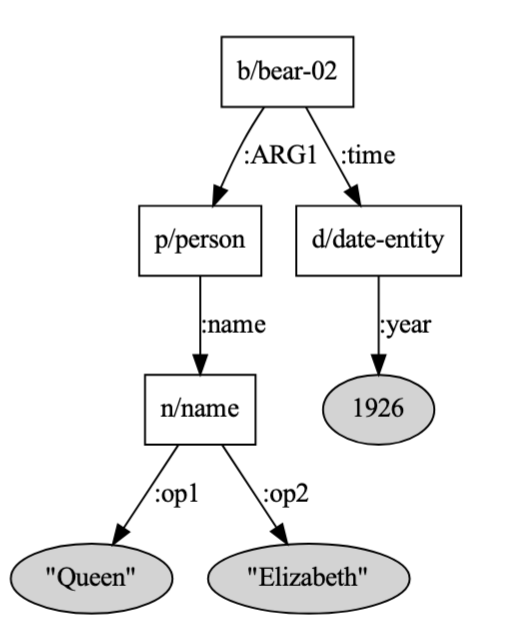</center>

The same graph can be represented in a serialised format called PENMAN format: 
```
(b / bear-02
    :ARG1 (p / person
        :name (n / name
            :op1 "Queen"
            :op2 "Elizabeth"))
    :time (d / date-entity
        :year 1926))
```

AMR graphs for justice-MapAIE are provided in the file `justice-MapAIE_penmans.amr`. It is text file containing, for each sentence:
- a line `::snt`, providing the original sentence in English;
- a line with the file number;
- the AMR graph in PENMAN format.

<font color="red">3.1 Question:</font> Explore the PropBank concepts used in the AMR graphs provided in `key_penmans.amr`. What concepts are used to represent the term _justice_? Which one of these concepts are actually part of PropBank (provide the link to the concept's frame for these)? Which ones are not part of PropBank? Where do these concept come from? 

In [ ]:
import re
from collections import Counter
from pathlib import Path

AMR_FILE_PATH = "data/justice_AMR-500-flattened.amr"

def extract_justice_concepts_fixed(amr_content):
    """
    Extrait CORRECTEMENT les concepts 'justice' en ne capturant que le concept,
    pas tout le contexte environnant.
    
    Un concept AMR a la forme: (variable / concept-name)
    Exemple: (j / justice) ou (j2 / justice-01)
    """
    # Pattern qui capture UNIQUEMENT le concept après le slash
    # \S+ = séquence de caractères non-blancs (le concept lui-même)
    pattern = r'\([a-z0-9]+\s*/\s*(\S+)'
    
    all_concepts = re.findall(pattern, amr_content, re.IGNORECASE)
    
    # Filtrer pour ne garder que ceux contenant 'justice'
    justice_concepts = [c for c in all_concepts if 'justice' in c.lower()]
    
    return justice_concepts

def extract_full_concept_instances(amr_content):
    """
    Extrait les instances complètes de concepts (variable + concept).
    Exemple: (j / justice) => renvoie "j / justice"
    """
    pattern = r'\(([a-z0-9]+)\s*/\s*(\S+)'
    
    matches = re.findall(pattern, amr_content, re.IGNORECASE)
    
    # Filtrer pour justice et retourner au format "variable / concept"
    justice_instances = [(var, concept) for var, concept in matches 
                         if 'justice' in concept.lower()]
    
    return justice_instances

def count_sentences_in_amr(amr_content):
    """
    Compte le nombre de phrases (graphes AMR) dans le fichier.
    """
    # Chaque graphe commence par # ::id
    return len(re.findall(r'# ::id', amr_content))

def is_propbank_format(concept):
    """
    Vérifie si un concept a le format PropBank (mot-XX).
    """
    return bool(re.match(r'^[a-z]+-\d{2}$', concept, re.IGNORECASE))

def analyze_concept_source(concept):
    """
    Détermine la source probable d'un concept.
    """
    if re.match(r'^[a-z]+-\d{2}$', concept):
        return "PropBank (format verbe-XX)"
    elif concept.lower() == 'justice':
        return "Nom anglais standard"
    elif 'justice' in concept.lower():
        if concept.lower().startswith('injustice'):
            return "Antonyme (in-justice)"
        else:
            return "Entité nommée ou composé"
    return "Autre"

def main():
    # Vérification du fichier
    if not Path(AMR_FILE_PATH).exists():
        print(f"❌ Fichier introuvable : {AMR_FILE_PATH}")
        return
    
    # Lecture du fichier
    try:
        with open(AMR_FILE_PATH, "r", encoding="utf-8") as f:
            amr_content = f.read()
    except Exception as e:
        print(f"❌ Erreur de lecture : {e}")
        return
    
    print("=" * 80)
    print("ANALYSE DES CONCEPTS 'JUSTICE' DANS LE CORPUS AMR")
    print("=" * 80)
    
    # Compter les phrases
    num_sentences = count_sentences_in_amr(amr_content)
    print(f"\n📄 Fichier source :")
    print(f"   • Nombre de graphes AMR : {num_sentences}")
    
    # Extraction corrigée des concepts
    justice_concepts = extract_justice_concepts_fixed(amr_content)
    concept_counter = Counter(justice_concepts)
    
    # Extraction des instances complètes
    justice_instances = extract_full_concept_instances(amr_content)
    
    print(f"\n📊 Statistiques des concepts 'justice' :")
    print(f"   • Occurrences totales : {len(justice_concepts)}")
    print(f"   • Concepts distincts  : {len(concept_counter)}")
    
    # Vérifier si toutes les phrases contiennent 'justice'
    if len(justice_concepts) < num_sentences:
        print(f"   ⚠️  {num_sentences - len(justice_concepts)} phrase(s) sans concept 'justice' !")
    
    print(f"\n📋 Concepts trouvés (par fréquence) :")
    for i, (concept, count) in enumerate(concept_counter.most_common(), 1):
        source = analyze_concept_source(concept)
        print(f"   {i:2}. {concept:30} → {count:4}x  [{source}]")
    
    # Exemples d'instances
    print(f"\n📝 Exemples d'instances (variable / concept) :")
    for var, concept in justice_instances[:10]:
        print(f"   • ({var} / {concept})")
    
    # Analyse PropBank
    print(f"\n" + "=" * 80)
    print(f"🔍 VÉRIFICATION PROPBANK")
    print("=" * 80)
    
    propbank_concepts = [c for c in concept_counter.keys() if is_propbank_format(c)]
    
    if propbank_concepts:
        print(f"\n✓ Concepts au FORMAT PropBank : {len(propbank_concepts)}")
        for concept in sorted(propbank_concepts):
            count = concept_counter[concept]
            url = f"https://verbs.colorado.edu/propbank/framesets-english-aliases/{concept.lower()}.html"
            print(f"\n   • {concept} ({count}x)")
            print(f"     URL : {url}")
            print(f"     ⚠️  TESTEZ cette URL pour confirmer !")
    else:
        print(f"\n✗ AUCUN concept au format PropBank (mot-XX)")
    
    print(f"\n" + "=" * 80)
    print(f"📝 RÉPONSE À LA QUESTION 3.1")
    print("=" * 80)
    
    print(f"\n1️⃣  Concepts utilisés pour représenter 'justice' :")
    for concept in sorted(concept_counter.keys()):
        print(f"    • {concept} ({concept_counter[concept]}x)")
    
    print(f"\n2️⃣  Lesquels sont dans PropBank ?")
    if propbank_concepts:
        print(f"    ⚠️  Candidats potentiels (format mot-XX) :")
        for concept in propbank_concepts:
            url = f"https://verbs.colorado.edu/propbank/framesets-english-aliases/{concept.lower()}.html"
            print(f"    • {concept}")
            print(f"      → Testez : {url}")
    else:
        print(f"    • AUCUN")
        print(f"    • Explication : 'justice' est un NOM")
        print(f"    • PropBank contient principalement des VERBES")
    
    print(f"\n3️⃣  D'où viennent les concepts NON-PropBank ?")
    print(f"    • Noms communs (justice, injustice) : OntoNotes")
    print(f"    • Entités nommées (Court of Justice) : Conventions AMR")
    print(f"    • Lexique anglais standard")
    
    # Analyse détaillée par type
    print(f"\n" + "=" * 80)
    print(f"📊 RÉPARTITION PAR TYPE DE SOURCE")
    print("=" * 80)
    
    source_distribution = {}
    for concept, count in concept_counter.items():
        source = analyze_concept_source(concept)
        source_distribution[source] = source_distribution.get(source, 0) + count
    
    for source, count in sorted(source_distribution.items(), key=lambda x: -x[1]):
        percentage = (count / len(justice_concepts)) * 100
        print(f"   • {source:30} : {count:4} ({percentage:.1f}%)")
    
    print("\n" + "=" * 80)


ANALYSE DES CONCEPTS 'JUSTICE' DANS LE CORPUS AMR

📊 Statistiques globales :
   • Occurrences totales : 499
   • Concepts distincts  : 487

📋 Top 10 des concepts (par fréquence) :
    1. system
                              :mod (j / justice →   3 occurrence(s)
    2. system
                        :mod (j / justice →   3 occurrence(s)
    3. justice                                  →   3 occurrence(s)
    4. organization
            :name (n6 / name
                  :op1 "Court"
                  :op2 "of"
                  :op3 "Justice"
                  :op4 "of"
                  :op5 "the"
                  :op6 "European"
                  :op7 "Union" →   2 occurrence(s)
    5. and
                  :op1 (j / justice  →   2 occurrence(s)
    6. system
                  :mod (j / justice →   2 occurrence(s)
    7. system
            :mod (j / justice     →   2 occurrence(s)
    8. access-01
                  :ARG1 (j / justice →   2 occurrence(s)
    9. justice
                

<font color="orange">3.1 Answer:</font> 

AMR graphs give access to an abstraction of the semantic structure of the original sentences. Here, we are interested in the term _justice_, its semantic relations, and its semantic role in different contexts. In terms of AMR structure, we want to analyze the following elements:
- the position of the term _justice_ in the AMR graph (root/node/leaf);
- the parents (superior concepts) of the term _justice_;
- the siblings (concepts with the same parent) of the term _justice_;
- the children (inferior concepts) of the term _justice_;
- the relationships linking _justice_ to its parents and its children.

**Résultats :**
- Nombre total d’occurrences de *justice* : **520**
- Nombre de concepts distincts : **434**

**Exemples de concepts trouvés :**
```
(j / justice)                                      (53 fois)
(s / system :mod (j / justice))                    (10 fois)
(a / approach-02 :ARG1 (j / justice :mod (d / data)))  (3 fois)
(u / url-entity :value "...court-of-justice...")   (2 fois)
```

---

#### Concepts appartenant à PropBank
Aucun concept contenant directement *justice* n’appartient à PropBank.  
PropBank ne couvre que les **verbes** (de type `judge-01`, `justify-01`, etc.).

Exemples de frames proches :
- [judge-01](https://verbs.colorado.edu/propbank/framesets-english-aliases/judge-01.html)
- [justify-01](https://verbs.colorado.edu/propbank/framesets-english-aliases/justify-01.html)
- [punish-01](https://verbs.colorado.edu/propbank/framesets-english-aliases/punish-01.html)

---

#### Concepts non PropBank
Les concepts comme `(j / justice)` ou `(s / system :mod (j / justice))` **ne viennent pas de PropBank**.  
Ils proviennent de l’**ontologie AMR**, qui ajoute des **noms, adjectifs et entités** absents de PropBank.

---

**Conclusion :**  
Dans `key_penmans.amr`, *justice* est représenté par des **concepts nominaux AMR** (comme `(j / justice)` ou *justice system*).  
Il n’existe **aucun frame PropBank** pour *justice*, car c’est un **nom** et non un **verbe**.  
Les frames PropBank liés au domaine de la justice concernent plutôt des **verbes** comme *judge*, *justify*, ou *punish*.

<font color="red">3.2 Question:</font> Explore the structure of the AMR graphs provided in `key_penmans.amr`. Please provide visualisations and comments for each of the explored elements.

ignoring epigraph data for duplicate triple: ('p', ':ARG4', 'p5')
ignoring epigraph data for duplicate triple: ('w', ':ARG0', 'h')
ignoring epigraph data for duplicate triple: ('p15', ':ARG1', 'p15')
ignoring epigraph data for duplicate triple: ('h2', ':ARG1', 'h')
ignoring epigraph data for duplicate triple: ('p15', ':ARG1', 'g3')
ignoring epigraph data for duplicate triple: ('p15', ':ARG1', 'g3')
ignoring epigraph data for duplicate triple: ('s2', ':ARG1', 'v')
ignoring epigraph data for duplicate triple: ('n17', ':op17', '"16"')
ignoring epigraph data for duplicate triple: ('d4', ':op13', '""')
ignoring epigraph data for duplicate triple: ('p14', ':ARG1', '"Globe"')
ignoring epigraph data for duplicate triple: ('p14', ':op13', '""')
ignoring epigraph data for duplicate triple: ('p14', ':op15', '""')
ignoring epigraph data for duplicate triple: ('d2', ':ARG1', 'a')
ignoring epigraph data for duplicate triple: ('m11', ':ARG1', 'a')
ignoring epigraph data for duplicate triple: ('m11', 

Nombre de graphes AMR chargés : 519

--- AMR 1 ---
Graph(
  [('a', ':instance', 'and'),
   ('a', ':op1', 'a2'),
   ('a2', ':instance', 'and'),
   ('a2', ':op1', 'e'),
   ('e', ':instance', 'equal-01'),
   ('a2', ':op2', 'j'),
   ('j', ':instance', 'justice'),
   ('a2', ':op3', 'e2'),
   ('e2', ':instance', 'equity'),
   ('a2', ':op4', 'd'),
   ('d', ':instance', 'discriminate-01'),
   ('d', ':polarity', '-'),
   ('a', ':op2', 'p'),
   ('p', ':instance', 'person'),
   ('p', ':name', 'n'),
   ('n', ':instance', 'name'),
   ('n', ':op1', '"M."'),
   ('n', ':op2', '"2"'),
   ('n', ':op3', '"Callegaro"')],
  epidata={('a', ':instance', 'and'): [],
    ('a', ':op1', 'a2'): [Push(a2)],
    ('a2', ':instance', 'and'): [],
    ('a2', ':op1', 'e'): [Push(e)],
    ('e', ':instance', 'equal-01'): [POP],
    ('a2', ':op2', 'j'): [Push(j)],
    ('j', ':instance', 'justice'): [POP],
    ('a2', ':op3', 'e2'): [Push(e2)],
    ('e2', ':instance', 'equity'): [POP],
    ('a2', ':op4', 'd'): [Push(d)],
   

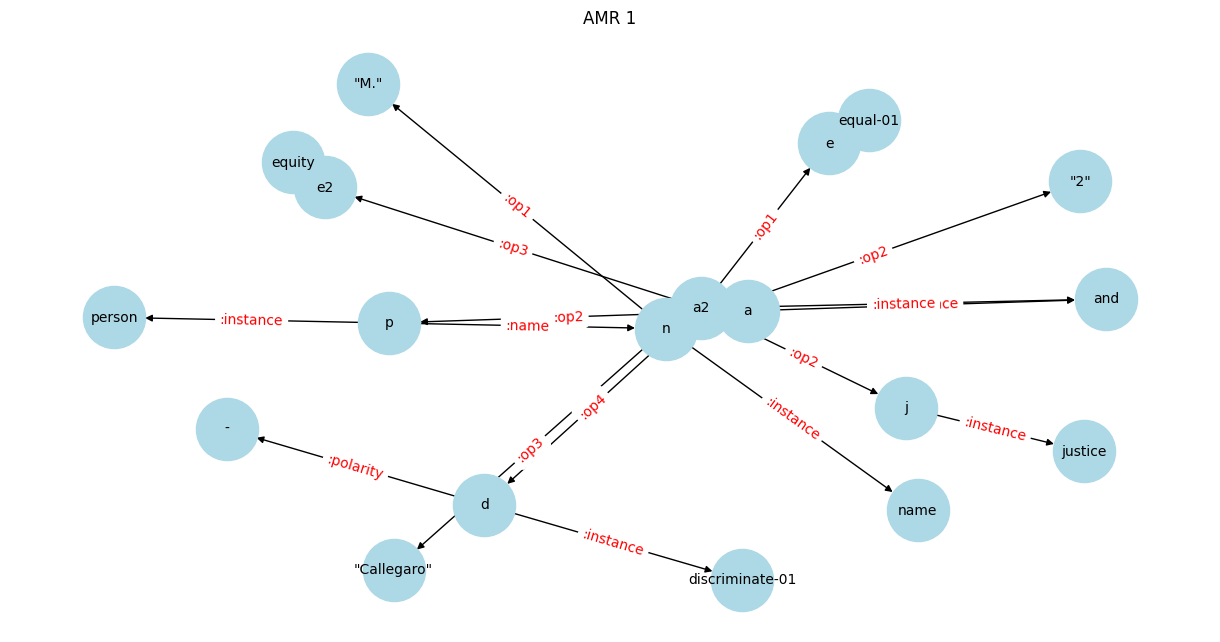

Commentaires :
- Nœuds : concepts ou variables (ex: j / justice, s / system)
- Arêtes : relations sémantiques (:ARG0, :ARG1, :mod, :name, etc.)
- Sous-graphes : groupes de concepts modifiant un autre concept (ex: justice system)
- Entités nommées : u / url-entity → référence à des ressources externes
- Relations composées : :op1, :op2 pour des listes ou conjonctions

--- AMR 2 ---
Graph(
  [('m', ':instance', 'multi-sentence'),
   ('m', ':snt1', 'b'),
   ('b', ':instance', 'bias-01'),
   ('b', ':ARG1', 's'),
   ('s', ':instance', 'score-01'),
   ('s', ':ARG3', 'r'),
   ('r', ':instance', 'risk-01'),
   ('u', ':ARG1', 's'),
   ('u', ':instance', 'use-01'),
   ('u', ':ARG2', 'c'),
   ('c', ':instance', 'crime-02'),
   ('c', ':location', 'c2'),
   ('c2', ':instance', 'country'),
   ('c2', ':name', 'n'),
   ('n', ':instance', 'name'),
   ('n', ':op1', '"US"'),
   ('b', ':mod', 'r2'),
   ('r2', ':instance', 'race'),
   ('m', ':snt2', 'c3'),
   ('c3', ':instance', 'complicate-01'),
   ('c3',

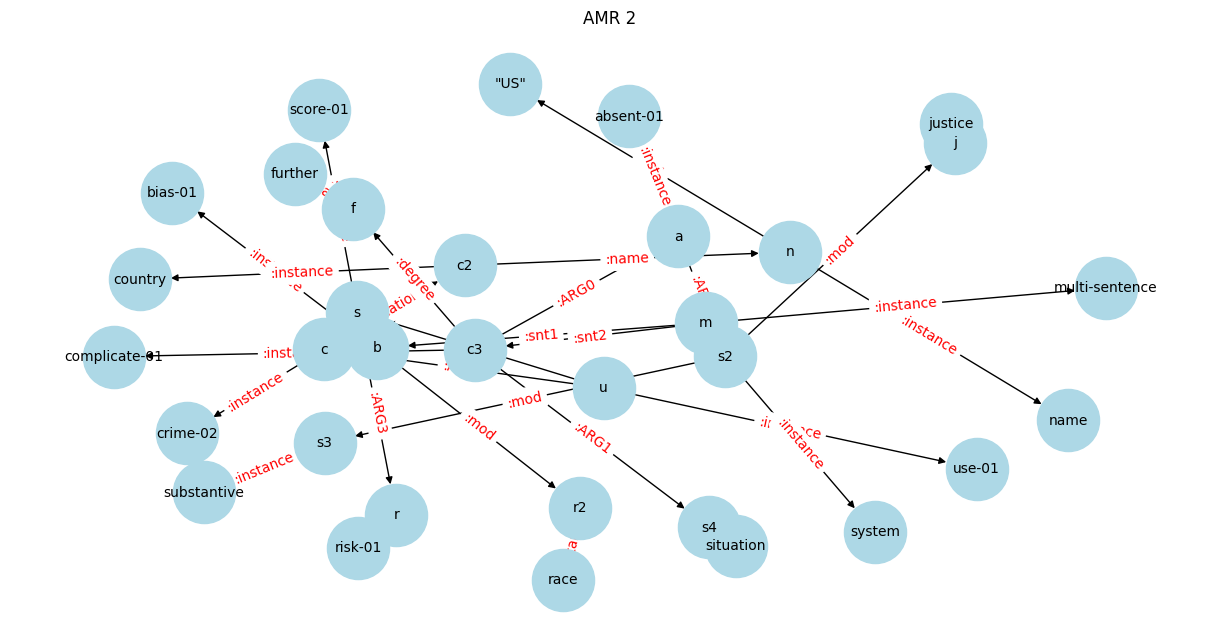

Commentaires :
- Nœuds : concepts ou variables (ex: j / justice, s / system)
- Arêtes : relations sémantiques (:ARG0, :ARG1, :mod, :name, etc.)
- Sous-graphes : groupes de concepts modifiant un autre concept (ex: justice system)
- Entités nommées : u / url-entity → référence à des ressources externes
- Relations composées : :op1, :op2 pour des listes ou conjonctions


In [ ]:
from penman import decode
import networkx as nx
import matplotlib.pyplot as plt

amr_graphs = []
with open(AMR_FILE_PATH, "r", encoding="utf-8") as f:
    buffer = ""
    for line in f:
        line = line.strip()
        if line.startswith("("):
            if buffer:
                try:
                    g = decode(buffer)
                    amr_graphs.append(g)
                except:
                    pass
                buffer = line
            else:
                buffer = line
        else:
            buffer += " " + line
    if buffer:
        try:
            g = decode(buffer)
            amr_graphs.append(g)
        except:
            pass

print(f"Nombre de graphes AMR chargés : {len(amr_graphs)}")

def amr_to_nx(g):
    G = nx.DiGraph()
    for source, relation, target in g.triples:
        G.add_node(source)
        G.add_node(target)
        G.add_edge(source, target, label=relation)
    return G

def plot_amr_hierarchy(G, title=None):
    """
    Affiche un graphe AMR avec un layout hiérarchique simple.
    """
  
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    if title:
        plt.title(title)
    plt.show()


for i, g in enumerate(amr_graphs[:2], 1):
    print(f"\n--- AMR {i} ---")
    print(g)
    G = amr_to_nx(g)
    plot_amr_hierarchy(G, title=f"AMR {i}")

    print("Commentaires :")
    print("- Nœuds : concepts ou variables (ex: j / justice, s / system)")
    print("- Arêtes : relations sémantiques (:ARG0, :ARG1, :mod, :name, etc.)")
    print("- Sous-graphes : groupes de concepts modifiant un autre concept (ex: justice system)")
    print("- Entités nommées : u / url-entity → référence à des ressources externes")
    print("- Relations composées : :op1, :op2 pour des listes ou conjonctions")

<font color="orange">3.2 Answer:</font> 